In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from scipy.stats import randint, loguniform
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold, LeavePOut, LeaveOneOut, cross_val_score
from sklearn.metrics import r2_score,confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve

In [3]:
data = pd.read_csv("Telecom Customers Churn.csv")
data.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
data.duplicated().sum()

0

In [6]:
data = data.drop_duplicates()

In [7]:
data = data.drop("customerID", axis=1)

In [8]:
for col in data.select_dtypes(include='object').columns:
    print(f"{col} : {data[col].unique()}")

gender : ['Female' 'Male']
Partner : ['Yes' 'No']
Dependents : ['No' 'Yes']
PhoneService : ['No' 'Yes']
MultipleLines : ['No phone service' 'No' 'Yes']
InternetService : ['DSL' 'Fiber optic' 'No']
OnlineSecurity : ['No' 'Yes' 'No internet service']
OnlineBackup : ['Yes' 'No' 'No internet service']
DeviceProtection : ['No' 'Yes' 'No internet service']
TechSupport : ['No' 'Yes' 'No internet service']
StreamingTV : ['No' 'Yes' 'No internet service']
StreamingMovies : ['No' 'Yes' 'No internet service']
Contract : ['Month-to-month' 'One year' 'Two year']
PaperlessBilling : ['Yes' 'No']
PaymentMethod : ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
TotalCharges : ['29.85' '1889.5' '108.15' ... '346.45' '306.6' '6844.5']
Churn : ['No' 'Yes']


In [9]:
# Converting Total Charges to a numerical data type.
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data['TotalCharges']

0         29.85
1       1889.50
2        108.15
3       1840.75
4        151.65
         ...   
7038    1990.50
7039    7362.90
7040     346.45
7041     306.60
7042    6844.50
Name: TotalCharges, Length: 7043, dtype: float64

In [10]:
data.isna().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

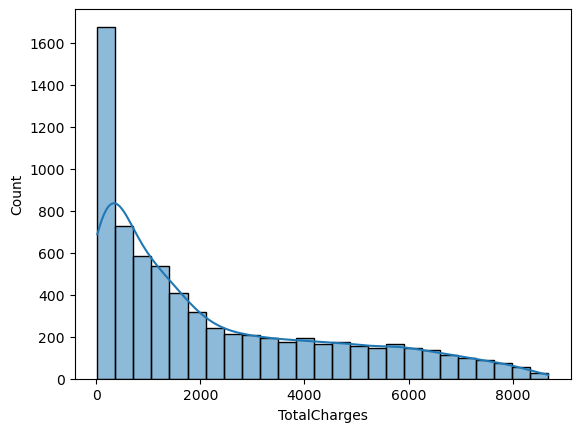

In [11]:
sns.histplot(x = "TotalCharges", data = data, kde = True)
plt.show()

In [12]:
# FIlls the missing values
data["TotalCharges"] = data["TotalCharges"].fillna(data["TotalCharges"].median())

In [13]:
data.isna().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

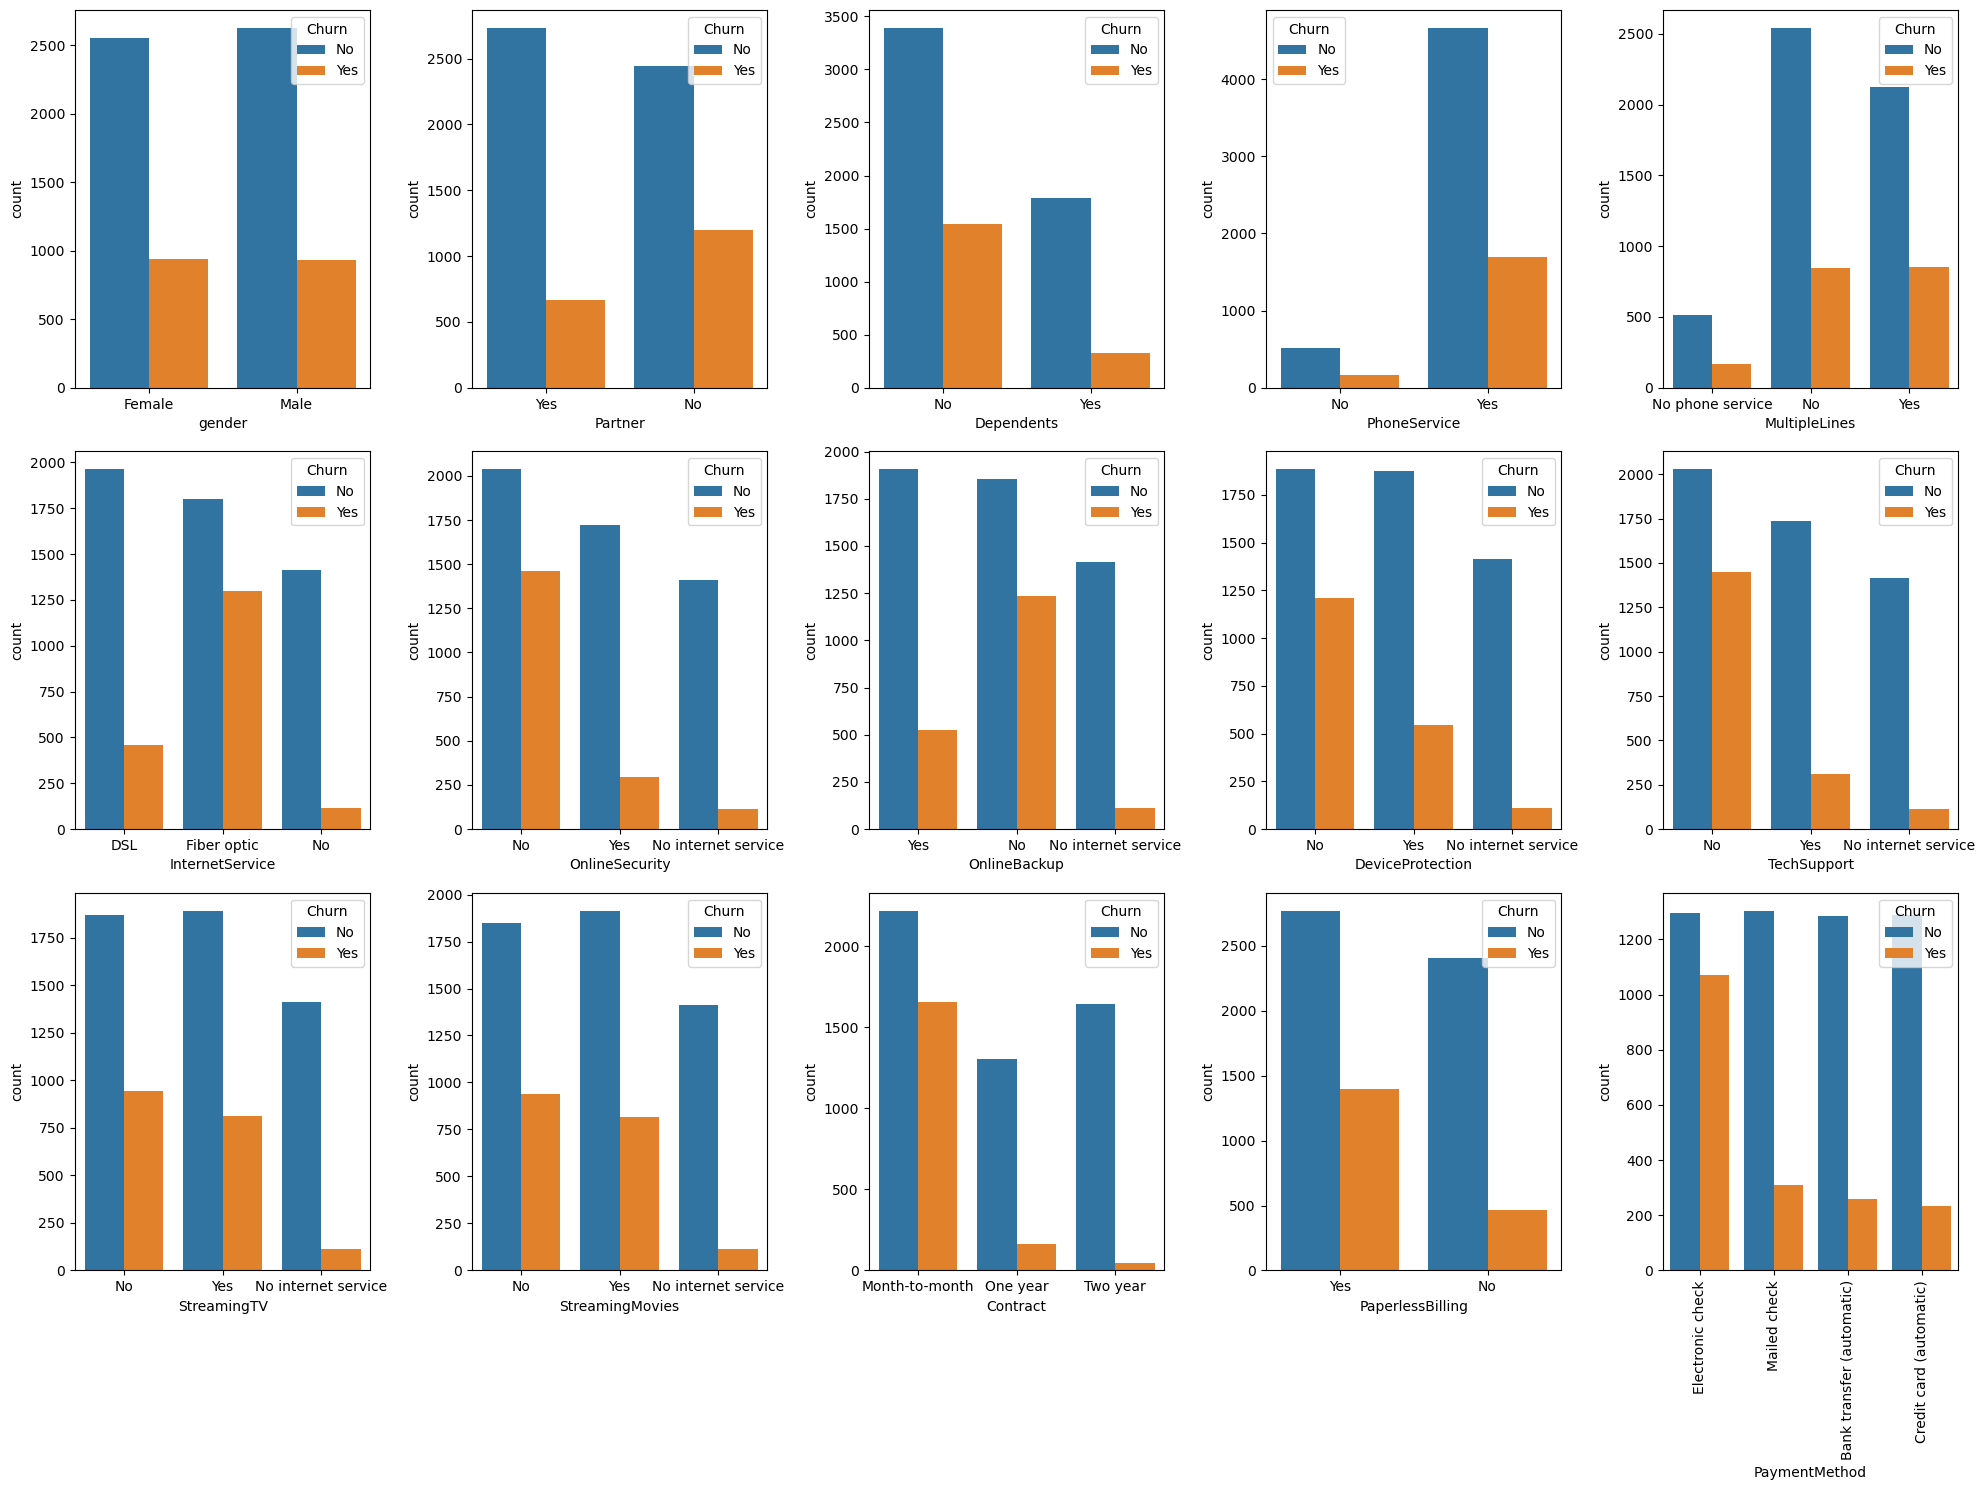

In [14]:
fig, ax = plt.subplots(3, 5, figsize=(20, 15))
ax = ax.ravel()

for i, col in enumerate(data.select_dtypes(include='object').columns):
  if col != 'Churn':
    sns.countplot(x = data[col], ax = ax[i], hue = data['Churn'])
  if i ==15:
        plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [15]:
df = data.copy()

In [16]:
# Create LTV (LifeTime Value)
data['LTV'] = data["MonthlyCharges"] * data["tenure"]
corr = data["TotalCharges"].corr(data["LTV"])
print(corr)

0.9992630844195209


In [17]:
data = data.drop(["LTV", "MonthlyCharges"], axis = 1)

In [18]:
# Create tensure_per_contract feature based on contract length
data["contract_length"] = data["Contract"].apply(lambda x: 1 if x == "Month-to-month" else (12 if x == "One year" else 24))
data["tenure_per_contract"] = data["tenure"] / data["contract_length"]
data = data.drop(["contract_length", "tenure", "Contract"], axis = 1)

In [19]:
# Create uses_streaming_services feature
data["uses_streaming_services"] = data.apply(lambda x: 1 if x["StreamingTV"] == 'Yes' or
                                             x["StreamingMovies"] == "Yes" else 0, axis = 1)
data = data.drop(["StreamingTV", "StreamingMovies"], axis = 1)

In [20]:
# Create num_additional_service
data['num_additional_services'] = data[['OnlineSecurity', 'OnlineBackup', 'TechSupport', 'DeviceProtection']].apply(lambda x: sum([1 if service == 'Yes' else 0 for service in x]), axis=1)
print(data[['OnlineSecurity', 'OnlineBackup', 'TechSupport', 'DeviceProtection']])
data = data.drop(["OnlineSecurity", "OnlineBackup", "TechSupport", "DeviceProtection"], axis = 1)
# Use pd.get_dummies instead of data.pd_get_dummies
data = pd.get_dummies(data, columns=['num_additional_services'], prefix='num_services', dtype = int)

     OnlineSecurity OnlineBackup TechSupport DeviceProtection
0                No          Yes          No               No
1               Yes           No          No              Yes
2               Yes          Yes          No               No
3               Yes           No         Yes              Yes
4                No           No          No               No
...             ...          ...         ...              ...
7038            Yes           No         Yes              Yes
7039             No          Yes          No              Yes
7040            Yes           No          No               No
7041             No           No          No               No
7042            Yes           No         Yes              Yes

[7043 rows x 4 columns]


In [21]:
# Defining a function to combine the two features
def combine_phone_features(row):
    if row['PhoneService'] == 'No':
        return 'No Phone Service'
    elif row['PhoneService'] == 'Yes' and row['MultipleLines'] == 'No':
        return 'Single Line'
    elif row['PhoneService'] == 'Yes' and row['MultipleLines'] == 'Yes':
        return 'Multiple Lines'
    else:
        return 'Unknown'

# Applying the function to create a new combined feature
data['PhoneServiceCombined'] = data.apply(combine_phone_features, axis=1)

# Display the first few rows of the new combined feature
print(data[['PhoneService', 'MultipleLines', 'PhoneServiceCombined']].head())

  PhoneService     MultipleLines PhoneServiceCombined
0           No  No phone service     No Phone Service
1          Yes                No          Single Line
2          Yes                No          Single Line
3           No  No phone service     No Phone Service
4          Yes                No          Single Line


In [22]:
data = data.drop(['PhoneService', 'MultipleLines'], axis = 1)

In [23]:
data.head()

gender  SeniorCitizen Partner Dependents InternetService PaperlessBilling  \
0  Female              0     Yes         No             DSL              Yes   
1    Male              0      No         No             DSL               No   
2    Male              0      No         No             DSL              Yes   
3    Male              0      No         No             DSL               No   
4  Female              0      No         No     Fiber optic              Yes   

               PaymentMethod  TotalCharges Churn  tenure_per_contract  \
0           Electronic check         29.85    No             1.000000   
1               Mailed check       1889.50    No             2.833333   
2               Mailed check        108.15   Yes             2.000000   
3  Bank transfer (automatic)       1840.75    No             3.750000   
4           Electronic check        151.65   Yes             2.000000   

   uses_streaming_services  num_services_0  num_services_1  num_services_2  \
0                        0               0               1               0   
1                        0               0               0               1   
2                        0               0               0               1   
3                        0               0               0               0   
4                        0               1               0               0   

   num_services_3  num_services_4 PhoneServiceCombined  
0               0               0     No Phone Service  
1               0               0          Single Line  
2               0               0          Single Line  
3               1               0     No Phone Service  
4               0               0          Single Line

In [24]:
data.describe().transpose()

count         mean          std   min      25%  \
SeniorCitizen            7043.0     0.162147     0.368612   0.0    0.000   
TotalCharges             7043.0  2281.916928  2265.270398  18.8  402.225   
tenure_per_contract      7043.0    11.225318    15.155933   0.0    2.250   
uses_streaming_services  7043.0     0.496805     0.500025   0.0    0.000   
num_services_0           7043.0     0.396564     0.489219   0.0    0.000   
num_services_1           7043.0     0.208292     0.406116   0.0    0.000   
num_services_2           7043.0     0.194803     0.396077   0.0    0.000   
num_services_3           7043.0     0.133608     0.340255   0.0    0.000   
num_services_4           7043.0     0.066733     0.249577   0.0    0.000   

                                 50%     75%     max  
SeniorCitizen               0.000000     0.0     1.0  
TotalCharges             1397.475000  3786.6  8684.8  
tenure_per_contract         3.916667    14.0    72.0  
uses_streaming_services     0.000000     1.0     1.0  
num_services_0              0.000000     1.0     1.0  
num_services_1              0.000000     0.0     1.0  
num_services_2              0.000000     0.0     1.0  
num_services_3              0.000000     0.0     1.0  
num_services_4              0.000000     0.0     1.0

In [25]:
# Encode Categorical data (2 classes) to numerical
enc_col_label = {}
for col in data.select_dtypes(include='object').columns:
  if len(data[col].unique()) < 3:
    enc_col_label[col] = data[col].unique().tolist()
    data[col] = data[col].map({x: i for i, x in enumerate(data[col].unique())})

# Encode Categorical data (more than 2 classes) to numerical
enc = OneHotEncoder(handle_unknown = "ignore", sparse_output = False)
categorical_cols = data.select_dtypes(include='object').columns
encoded = enc.fit_transform(data[categorical_cols])
encoded = pd.DataFrame(encoded, columns = enc.get_feature_names_out(categorical_cols), index = data.index)
data = pd.concat([data, encoded], axis = 1).drop(columns = categorical_cols, axis = 1)

In [26]:
data.head()

gender  SeniorCitizen  Partner  Dependents  PaperlessBilling  TotalCharges  \
0       0              0        0           0                 0         29.85   
1       1              0        1           0                 1       1889.50   
2       1              0        1           0                 0        108.15   
3       1              0        1           0                 1       1840.75   
4       0              0        1           0                 0        151.65   

   Churn  tenure_per_contract  uses_streaming_services  num_services_0  ...  \
0      0             1.000000                        0               0  ...   
1      0             2.833333                        0               0  ...   
2      1             2.000000                        0               0  ...   
3      0             3.750000                        0               0  ...   
4      1             2.000000                        0               1  ...   

   InternetService_DSL  InternetService_Fiber optic  InternetService_No  \
0                  1.0                          0.0                 0.0   
1                  1.0                          0.0                 0.0   
2                  1.0                          0.0                 0.0   
3                  1.0                          0.0                 0.0   
4                  0.0                          1.0                 0.0   

   PaymentMethod_Bank transfer (automatic)  \
0                                      0.0   
1                                      0.0   
2                                      0.0   
3                                      1.0   
4                                      0.0   

   PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
0                                    0.0                             1.0   
1                                    0.0                             0.0   
2                                    0.0                             0.0   
3                                    0.0                             0.0   
4                                    0.0                             1.0   

   PaymentMethod_Mailed check  PhoneServiceCombined_Multiple Lines  \
0                         0.0                                  0.0   
1                         1.0                                  0.0   
2                         1.0                                  0.0   
3                         0.0                                  0.0   
4                         0.0                                  0.0   

   PhoneServiceCombined_No Phone Service  PhoneServiceCombined_Single Line  
0                                    1.0                               0.0  
1                                    0.0                               1.0  
2                                    0.0                               1.0  
3                                    1.0                               0.0  
4                                    0.0                               1.0  

[5 rows x 24 columns]

In [27]:
decimal_cols = [col for col in data.columns if 1 < data[col].max()]

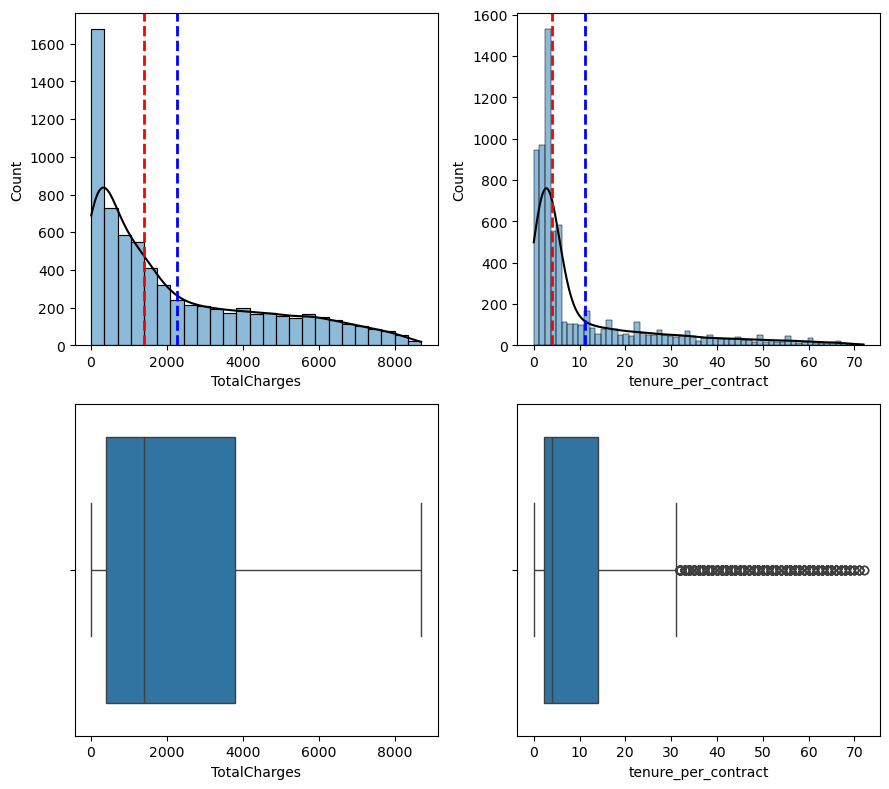

In [28]:
# Check for outliers
fig, ax = plt.subplots(2, 2, figsize=(9, 8))
ax = ax.ravel()

for i, col in enumerate(decimal_cols):
  hist = sns.histplot(x = data[col], ax = ax[i], kde = True)
  hist.lines[0].set_color('black')
  hist.axvline(x = data[col].mean(), color = 'b', label = 'mean', linestyle = "--", linewidth = 2)
  hist.axvline(x = data[col].median(), color = 'r', label = "median", linestyle = "--", linewidth = 2)
  sns.boxplot(x = data[col], ax = ax[i + 2])
plt.tight_layout()
plt.show()

In [29]:
# Calculate the IQR for a numerical column (e.g., 'tenure_per_contract')
Q1 = data['tenure_per_contract'].quantile(0.25)
Q3 = data['tenure_per_contract'].quantile(0.75)
IQR = Q3 - Q1

# Define the outlier range
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Detect outliers
outliers = [x for x in data["tenure_per_contract"] if x < lower_bound or x > upper_bound]

# # Remove outliers from the entire DataFrame
# data.loc[(data["tenure_per_contract"] < lower_bound), "tenure_per_contract"] = lower_bound
# data.loc[(data["tenure_per_contract"] > upper_bound), "tenure_per_contract"] = upper_bound

# Print the outliers
print(f'{len(outliers)} outliers of total {len(data["tenure_per_contract"])} elements in "tenure_per_contract" feature')

840 outliers of total 7043 elements in "tenure_per_contract" feature


In [30]:
data[decimal_cols] = np.log1p(data[decimal_cols])

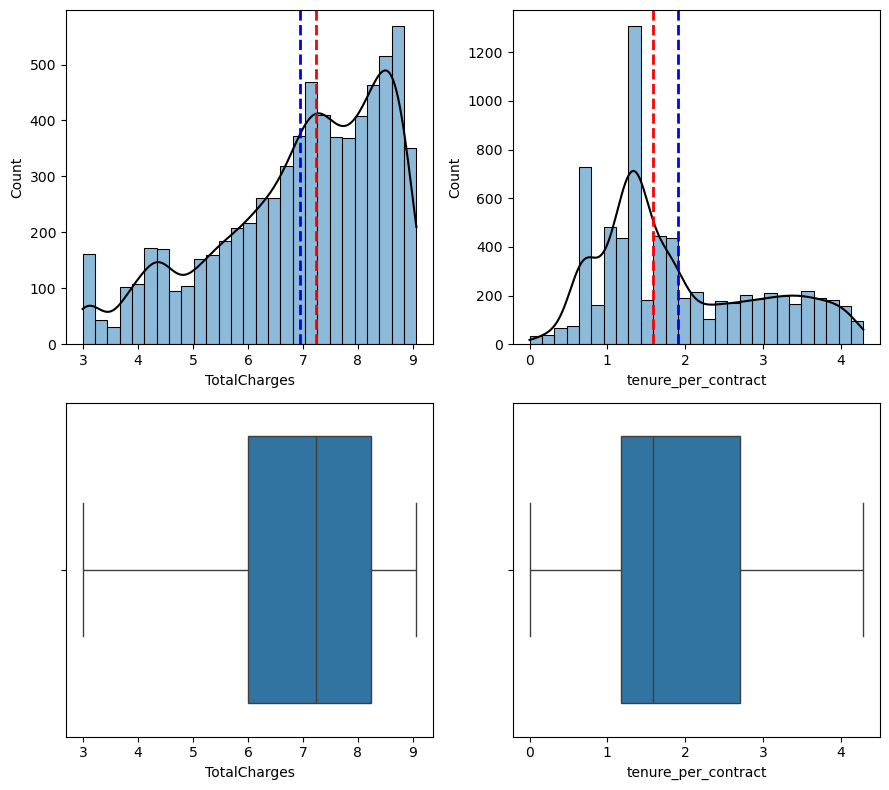

In [31]:
# Check for outliers
fig, ax = plt.subplots(2, 2, figsize=(9, 8))
ax = ax.ravel()

for i, col in enumerate(decimal_cols):
  hist = sns.histplot(x = data[col], ax = ax[i], kde = True)
  hist.lines[0].set_color('black')
  hist.axvline(x = data[col].mean(), color = 'b', label = 'mean', linestyle = "--", linewidth = 2)
  hist.axvline(x = data[col].median(), color = 'r', label = "median", linestyle = "--", linewidth = 2)
  sns.boxplot(x = data[col], ax = ax[i + 2])
plt.tight_layout()
plt.show()

In [32]:
df_scaled = data.copy()

In [33]:
X = data.drop("Churn", axis=1)
y = data["Churn"]

In [34]:
X_scaled = X.copy()
y_scaled = y.copy()

In [35]:
print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (7043, 23), y shape: (7043,)


<Axes: xlabel='Churn', ylabel='count'>

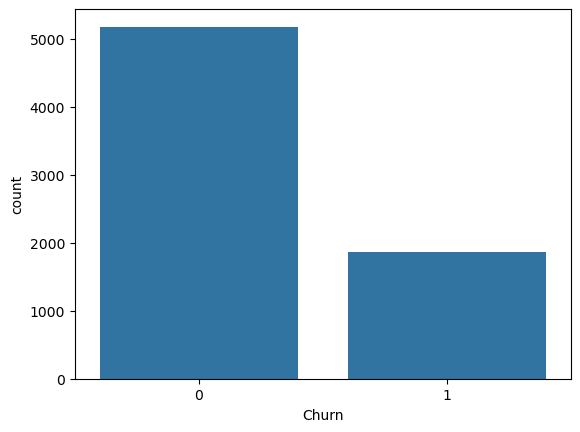

In [36]:
sns.countplot(x = y)

In [37]:
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

# Classification Part

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Hyperparameters tuning

In [39]:
def hyperParameters_tuning(model, parameters, tuning = ['grid', 'random']):
  search_algo = None
  if tuning == 'grid':
    search_algo = GridSearchCV(model,
                              parameters,
                              scoring = 'f1',
                              return_train_score=True,
                              cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                              n_jobs = -1,
                              verbose = 1)
  else:
    search_algo = RandomizedSearchCV(model,
                                     parameters,
                                     scoring = 'f1',
                                     return_train_score=True,
                                     cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                                     n_jobs = -1,
                                     verbose = 1,
                                     random_state = 42)
  search_algo.fit(X, y)
  return search_algo.best_params_

## Model Selection

### Logistic Regression

In [40]:
from sklearn.linear_model import LogisticRegression

In [41]:
log_reg = LogisticRegression(random_state = 42, max_iter = 100)

In [42]:
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
y_prob_class_1 = log_reg.predict_proba(X_test)[:, 1]

C:\Users\WIN-10\anaconda3\envs\NeuronetiX\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [43]:
# Test overfitting
print("Logistic Regression Train Score: ", log_reg.score(X_train, y_train))
print("Logistic Regression Test score: ", log_reg.score(X_test, y_test))

Logistic Regression Train Score:  0.7882338729161633
Logistic Regression Test score:  0.8009661835748793


#### Model Evaluation

##### Confusion Matrix

In [44]:
print(enc_col_label)

{'gender': ['Female', 'Male'], 'Partner': ['Yes', 'No'], 'Dependents': ['No', 'Yes'], 'PaperlessBilling': ['Yes', 'No'], 'Churn': ['No', 'Yes']}


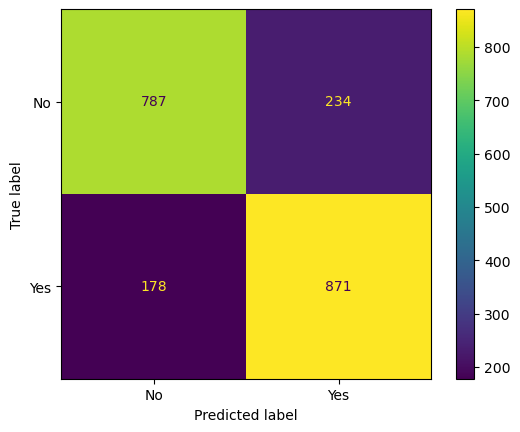

In [45]:

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = enc_col_label['Churn'])
disp.plot()
plt.show()

In [46]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.77      0.79      1021
           1       0.79      0.83      0.81      1049

    accuracy                           0.80      2070
   macro avg       0.80      0.80      0.80      2070
weighted avg       0.80      0.80      0.80      2070



##### AUC-ROC Curve

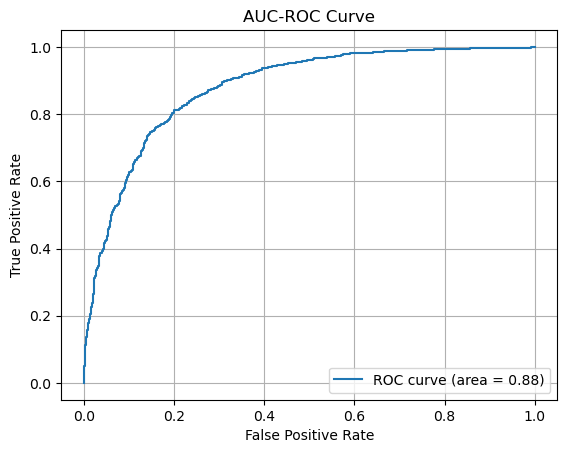

In [47]:
fpr, tpr, thesholds = roc_curve(y_test, y_prob_class_1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label = f"ROC curve (area = {roc_auc:0.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve")
plt.legend(loc = 'lower right')
plt.grid(True)
plt.show()

##### Precision-Recall Curve

In [48]:
# precision, recall, thresholds = precision_recall_curve(y_test, y_prob_class_1)
# auc_score = auc(recall, precision)
# plt.plot(recall, precision, label = f"precision_recall_curve (area = {auc_score:0.2f})")
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision-Recall Curve')
# plt.legend()
# plt.grid(True)
# plt.show()

### Random Forest

In [49]:
from sklearn.ensemble import RandomForestClassifier

In [50]:
RF = RandomForestClassifier()
parameters = {'criterion':['gini', 'entropy', 'log_loss'],
              'max_depth': randint(1, 20),
              'n_estimators': randint(10, 100)}

In [51]:
RF_hyperparameters = hyperParameters_tuning(RF, parameters, tuning = "random")
print(RF_hyperparameters.items())
RF = RandomForestClassifier(random_state = 42, n_estimators= RF_hyperparameters['n_estimators'], criterion = RF_hyperparameters['criterion'], max_depth= RF_hyperparameters['max_depth'])

Fitting 5 folds for each of 10 candidates, totalling 50 fits
dict_items([('criterion', 'log_loss'), ('max_depth', 15), ('n_estimators', 81)])


In [52]:
RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)
y_prob_class_1 = RF.predict_proba(X_test)[:, 1]

In [53]:
# Test overfitting
print("Random Forest Train Score: ", RF.score(X_train, y_train))
print("Random Forest Test score: " , RF.score(X_test, y_test))

Random Forest Train Score:  0.9542159942014979
Random Forest Test score:  0.8463768115942029


#### Model Evaluation

##### Confusion Matrix

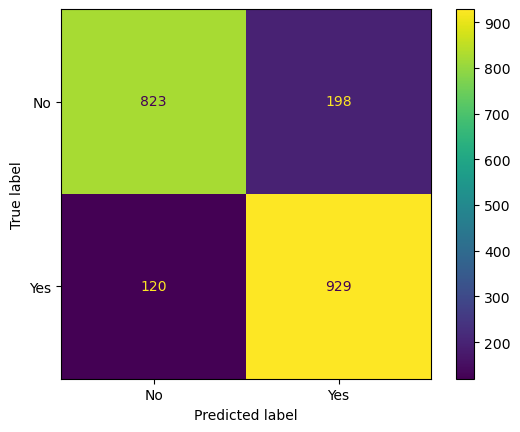

In [54]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = enc_col_label['Churn'])
disp.plot()

In [55]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.81      0.84      1021
           1       0.82      0.89      0.85      1049

    accuracy                           0.85      2070
   macro avg       0.85      0.85      0.85      2070
weighted avg       0.85      0.85      0.85      2070



##### AUC-ROC

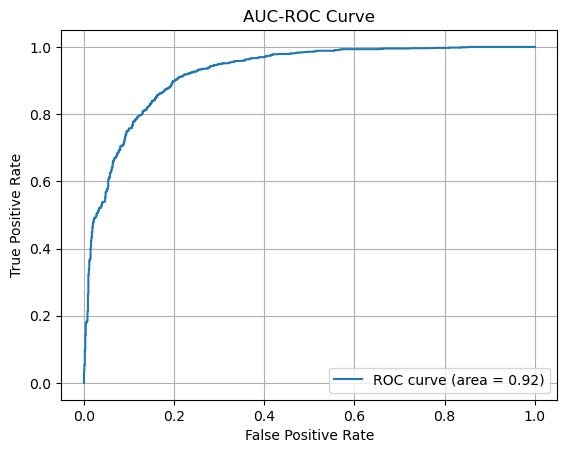

In [56]:
fpr, tpr, thesholds = roc_curve(y_test, y_prob_class_1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label = f"ROC curve (area = {roc_auc:0.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve")
plt.legend(loc = 'lower right')
plt.grid(True)
plt.show()

##### Precision-Recall Curve

In [57]:
# precision, recall, thresholds = precision_recall_curve(y_test, y_prob_class_1)
# auc_score = auc(recall, precision)
# plt.plot(recall, precision, label = f"precision_recall_curve (area = {auc_score:0.2f})")
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision-Recall Curve')
# plt.legend()
# plt.grid(True)
# plt.show()

### KNN

In [58]:
from sklearn.neighbors import KNeighborsClassifier

#### Selecting best K

Best K: 3, Accuracy: 81.03%


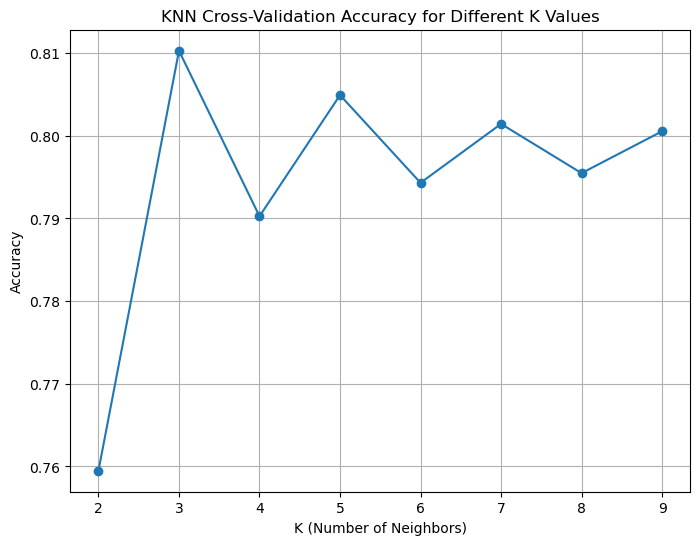

In [59]:
k_values = list(range(2, 10))
cross_val_accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    # cross validation if data in sequence, result the model no overfitting or no sequence (only pattern)
    scores = cross_val_score(knn,X_train, y_train, cv=5, scoring = 'f1')  # Using 5-fold cross-validation
    cross_val_accuracies.append(scores.mean())

# Find the best K value
best_k = k_values[cross_val_accuracies.index(max(cross_val_accuracies))]
best_accuracy = max(cross_val_accuracies)

print(f"Best K: {best_k}, Accuracy: {best_accuracy * 100:.2f}%")

# Plot the cross-validation accuracy for different K values
plt.figure(figsize=(8, 6))
plt.plot(k_values, cross_val_accuracies, marker='o', linestyle='-')
plt.title('KNN Cross-Validation Accuracy for Different K Values')
plt.xlabel('K (Number of Neighbors)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

In [60]:
knn = KNeighborsClassifier(n_neighbors = best_k)

In [61]:
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
y_prob_class_1 = knn.predict_proba(X_test)[:, 1]

In [62]:
# Test overfitting
print("Kneighbors Train Score: ", knn.score(X_train, y_train))
print("Kneighbors Test score: ", knn.score(X_test, y_test))

Kneighbors Train Score:  0.8949021502778449
Kneighbors Test score:  0.8144927536231884


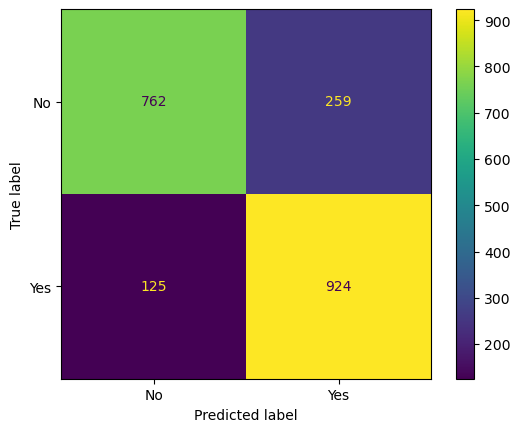

In [63]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = enc_col_label['Churn'])
disp.plot()

In [64]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.75      0.80      1021
           1       0.78      0.88      0.83      1049

    accuracy                           0.81      2070
   macro avg       0.82      0.81      0.81      2070
weighted avg       0.82      0.81      0.81      2070



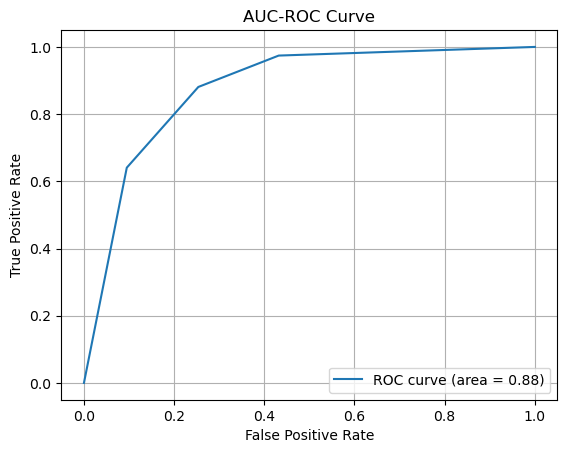

In [65]:
fpr, tpr, thesholds = roc_curve(y_test, y_prob_class_1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label = f"ROC curve (area = {roc_auc:0.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve")
plt.legend(loc = 'lower right')
plt.grid(True)
plt.show()

# Clustering Part

## KMeans

In [66]:
from scipy.cluster import hierarchy
from scipy.spatial import distance_matrix
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

### KMean algorithm

In [67]:
df_cluster = df.copy()
df_prediction = df.copy()
df_cluster.head()

gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  Female              0     Yes         No       1           No   
1    Male              0      No         No      34          Yes   
2    Male              0      No         No       2          Yes   
3    Male              0      No         No      45           No   
4  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1              Yes          No          No              No        One year   
2               No          No          No              No  Month-to-month   
3              Yes         Yes          No              No        One year   
4               No          No          No              No  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges  TotalCharges  \
0              Yes           Electronic check           29.85         29.85   
1               No               Mailed check           56.95       1889.50   
2              Yes               Mailed check           53.85        108.15   
3               No  Bank transfer (automatic)           42.30       1840.75   
4              Yes           Electronic check           70.70        151.65   

  Churn  
0    No  
1    No  
2   Yes  
3    No  
4   Yes

In [68]:
def map_clusters(clusters):
    return [(cluster + 1) % 3 for cluster in clusters]

In [69]:
df_cluster = df_cluster.drop(["gender", "PhoneService"], axis = 1)

In [70]:
# Encode Categorical data to numerical
enc_col_label_cluster = {}

for col in df_cluster.select_dtypes(include='object').columns:
  enc_col_label_cluster[col] = df_cluster[col].unique().tolist()
  df_cluster[col] = df_cluster[col].map({x: i for i, x in enumerate(df_cluster[col].unique())})

In [71]:
df_cluster.head()

SeniorCitizen  Partner  Dependents  tenure  MultipleLines  InternetService  \
0              0        0           0       1              0                0   
1              0        1           0      34              1                0   
2              0        1           0       2              1                0   
3              0        1           0      45              0                0   
4              0        1           0       2              1                1   

   OnlineSecurity  OnlineBackup  DeviceProtection  TechSupport  StreamingTV  \
0               0             0                 0            0            0   
1               1             1                 1            0            0   
2               1             0                 0            0            0   
3               1             1                 1            1            0   
4               0             1                 0            0            0   

   StreamingMovies  Contract  PaperlessBilling  PaymentMethod  MonthlyCharges  \
0                0         0                 0              0           29.85   
1                0         1                 1              1           56.95   
2                0         0                 0              1           53.85   
3                0         1                 1              2           42.30   
4                0         0                 0              0           70.70   

   TotalCharges  Churn  
0         29.85      0  
1       1889.50      0  
2        108.15      1  
3       1840.75      0  
4        151.65      1

In [72]:
X_cluster = df_cluster.drop("Churn", axis = 1)

In [73]:
X_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SeniorCitizen     7043 non-null   int64  
 1   Partner           7043 non-null   int64  
 2   Dependents        7043 non-null   int64  
 3   tenure            7043 non-null   int64  
 4   MultipleLines     7043 non-null   int64  
 5   InternetService   7043 non-null   int64  
 6   OnlineSecurity    7043 non-null   int64  
 7   OnlineBackup      7043 non-null   int64  
 8   DeviceProtection  7043 non-null   int64  
 9   TechSupport       7043 non-null   int64  
 10  StreamingTV       7043 non-null   int64  
 11  StreamingMovies   7043 non-null   int64  
 12  Contract          7043 non-null   int64  
 13  PaperlessBilling  7043 non-null   int64  
 14  PaymentMethod     7043 non-null   int64  
 15  MonthlyCharges    7043 non-null   float64
 16  TotalCharges      7043 non-null   float64


In [74]:
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X_cluster)
data_pca = pd.DataFrame(X_pca, columns = ["PCA1", "PCA2"])

### Elbow visualizer

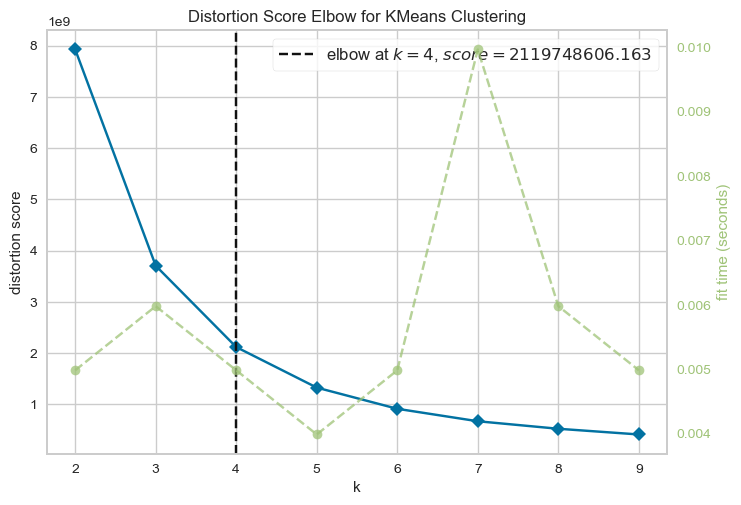

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [75]:
km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(2,10))

visualizer.fit(data_pca)
visualizer.show()

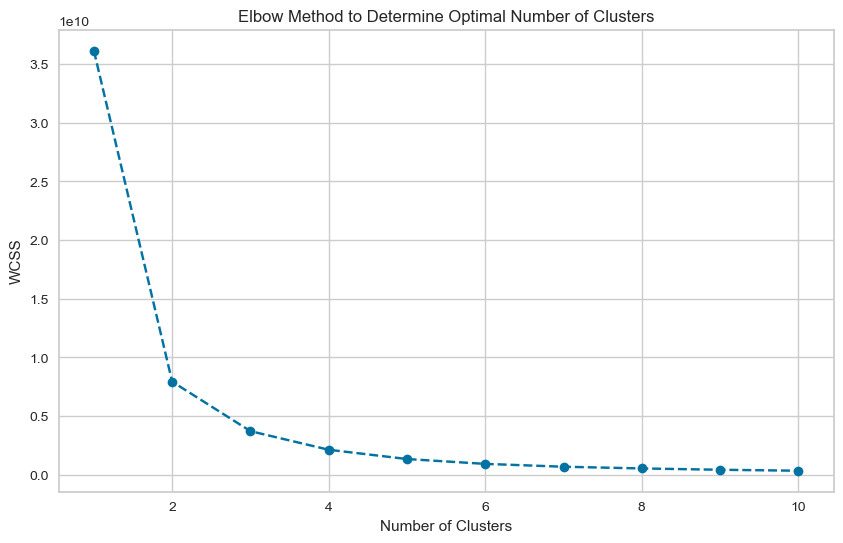

In [76]:
wcss = []  
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)


plt.figure(figsize=(10,6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method to Determine Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [77]:
optimal_clusters = 3

In [78]:
km3 = KMeans(n_clusters = optimal_clusters, random_state = 42)

In [79]:
km3.fit(data_pca)
clusters = km3.labels_

In [80]:
clusters = map_clusters(clusters)

In [81]:
silhouette_avg = silhouette_score(data_pca, clusters)
print(f'Silhouette Score for {optimal_clusters} clusters: {silhouette_avg}')

Silhouette Score for 3 clusters: 0.6442000413688543


In [82]:
df["Cluster"] = clusters

In [83]:
df.head()

gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  Female              0     Yes         No       1           No   
1    Male              0      No         No      34          Yes   
2    Male              0      No         No       2          Yes   
3    Male              0      No         No      45           No   
4  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  ...  \
0  No phone service             DSL             No          Yes  ...   
1                No             DSL            Yes           No  ...   
2                No             DSL            Yes          Yes  ...   
3  No phone service             DSL            Yes           No  ...   
4                No     Fiber optic             No           No  ...   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges  Churn Cluster  
0           Electronic check          29.85         29.85     No       0  
1               Mailed check          56.95       1889.50     No       0  
2               Mailed check          53.85        108.15    Yes       0  
3  Bank transfer (automatic)          42.30       1840.75     No       0  
4           Electronic check          70.70        151.65    Yes       0  

[5 rows x 21 columns]

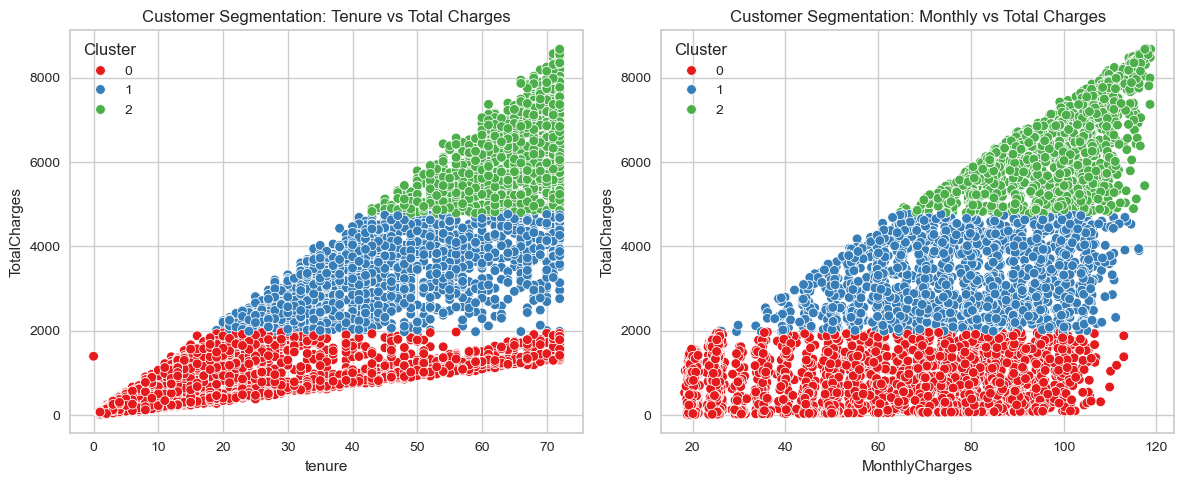

In [84]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns
axes = axes.ravel()

# Plot tenure vs TotalCharges
sns.scatterplot(x='tenure', y='TotalCharges', data=df, hue='Cluster', palette='Set1', ax=axes[0])
axes[0].set_title('Customer Segmentation: Tenure vs Total Charges')

# Plot MonthlyCharges vs TotalCharges
sns.scatterplot(x='MonthlyCharges', y='TotalCharges', data=df, hue='Cluster', palette='Set1', ax=axes[1])
axes[1].set_title('Customer Segmentation: Monthly vs Total Charges')

# Display the plots
plt.tight_layout()
plt.show()

In [85]:
cluster0 = df[df["Cluster"] == 0]
cluster1 = df[df["Cluster"] == 1]
cluster2 = df[df["Cluster"] == 2]
clusters = [cluster0, cluster1, cluster2]

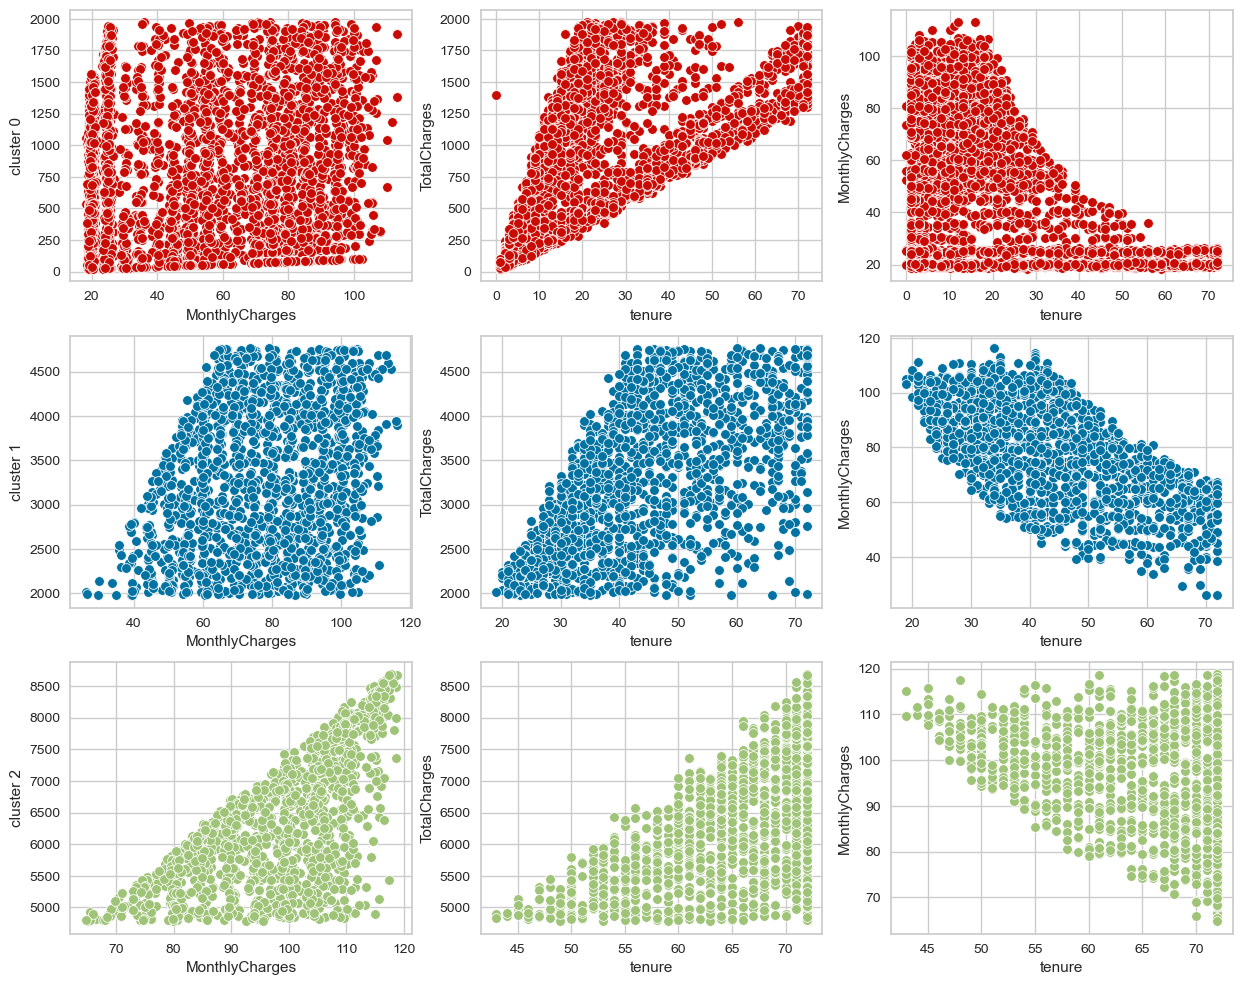

In [86]:
fig, ax = plt.subplots(3, 3, figsize = (15, 12))
colors = ['r', 'b', 'g']

for i, cluster in enumerate(clusters):
  ax[i][0].set_ylabel(f"cluster {i}")
  sns.scatterplot(x = "MonthlyCharges", y = "TotalCharges", data = cluster, ax = ax[i][0], color=colors[i])
  sns.scatterplot(x = "tenure", y = "TotalCharges", data = cluster, ax = ax[i][1], color = colors[i])
  sns.scatterplot(x = "tenure", y = "MonthlyCharges", data = cluster, ax = ax[i][2], color = colors[i])
plt.show()

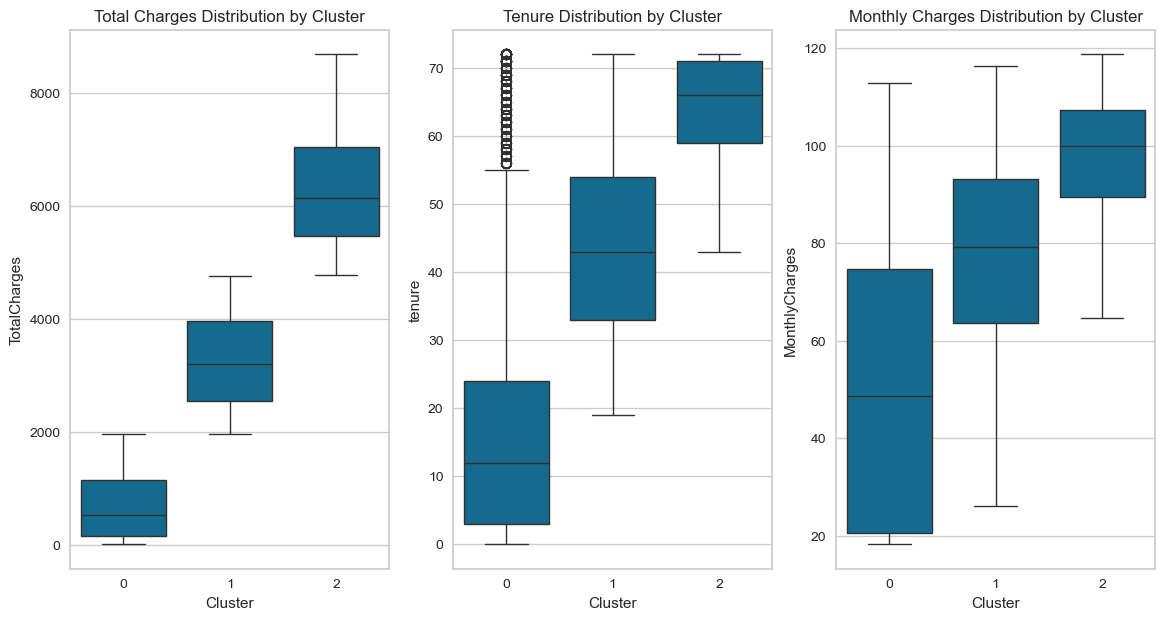

In [87]:
fig, axs = plt.subplots(1, 3, figsize=(14, 7))
sns.boxplot(x='Cluster', y = "TotalCharges", data=df, ax=axs[0]).set_title('Total Charges Distribution by Cluster')
sns.boxplot(x='Cluster', y='tenure', data=df, ax=axs[1]).set_title('Tenure Distribution by Cluster')
sns.boxplot(x='Cluster', y='MonthlyCharges', data=df, ax=axs[2]).set_title('Monthly Charges Distribution by Cluster')
plt.show()

In [88]:
df['Cluster'] = df['Cluster'].astype('str')

C:\Users\WIN-10\AppData\Local\Temp\ipykernel_19988\3989707512.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[j].set_xticklabels(ax[j].get_xticklabels(), rotation=90)


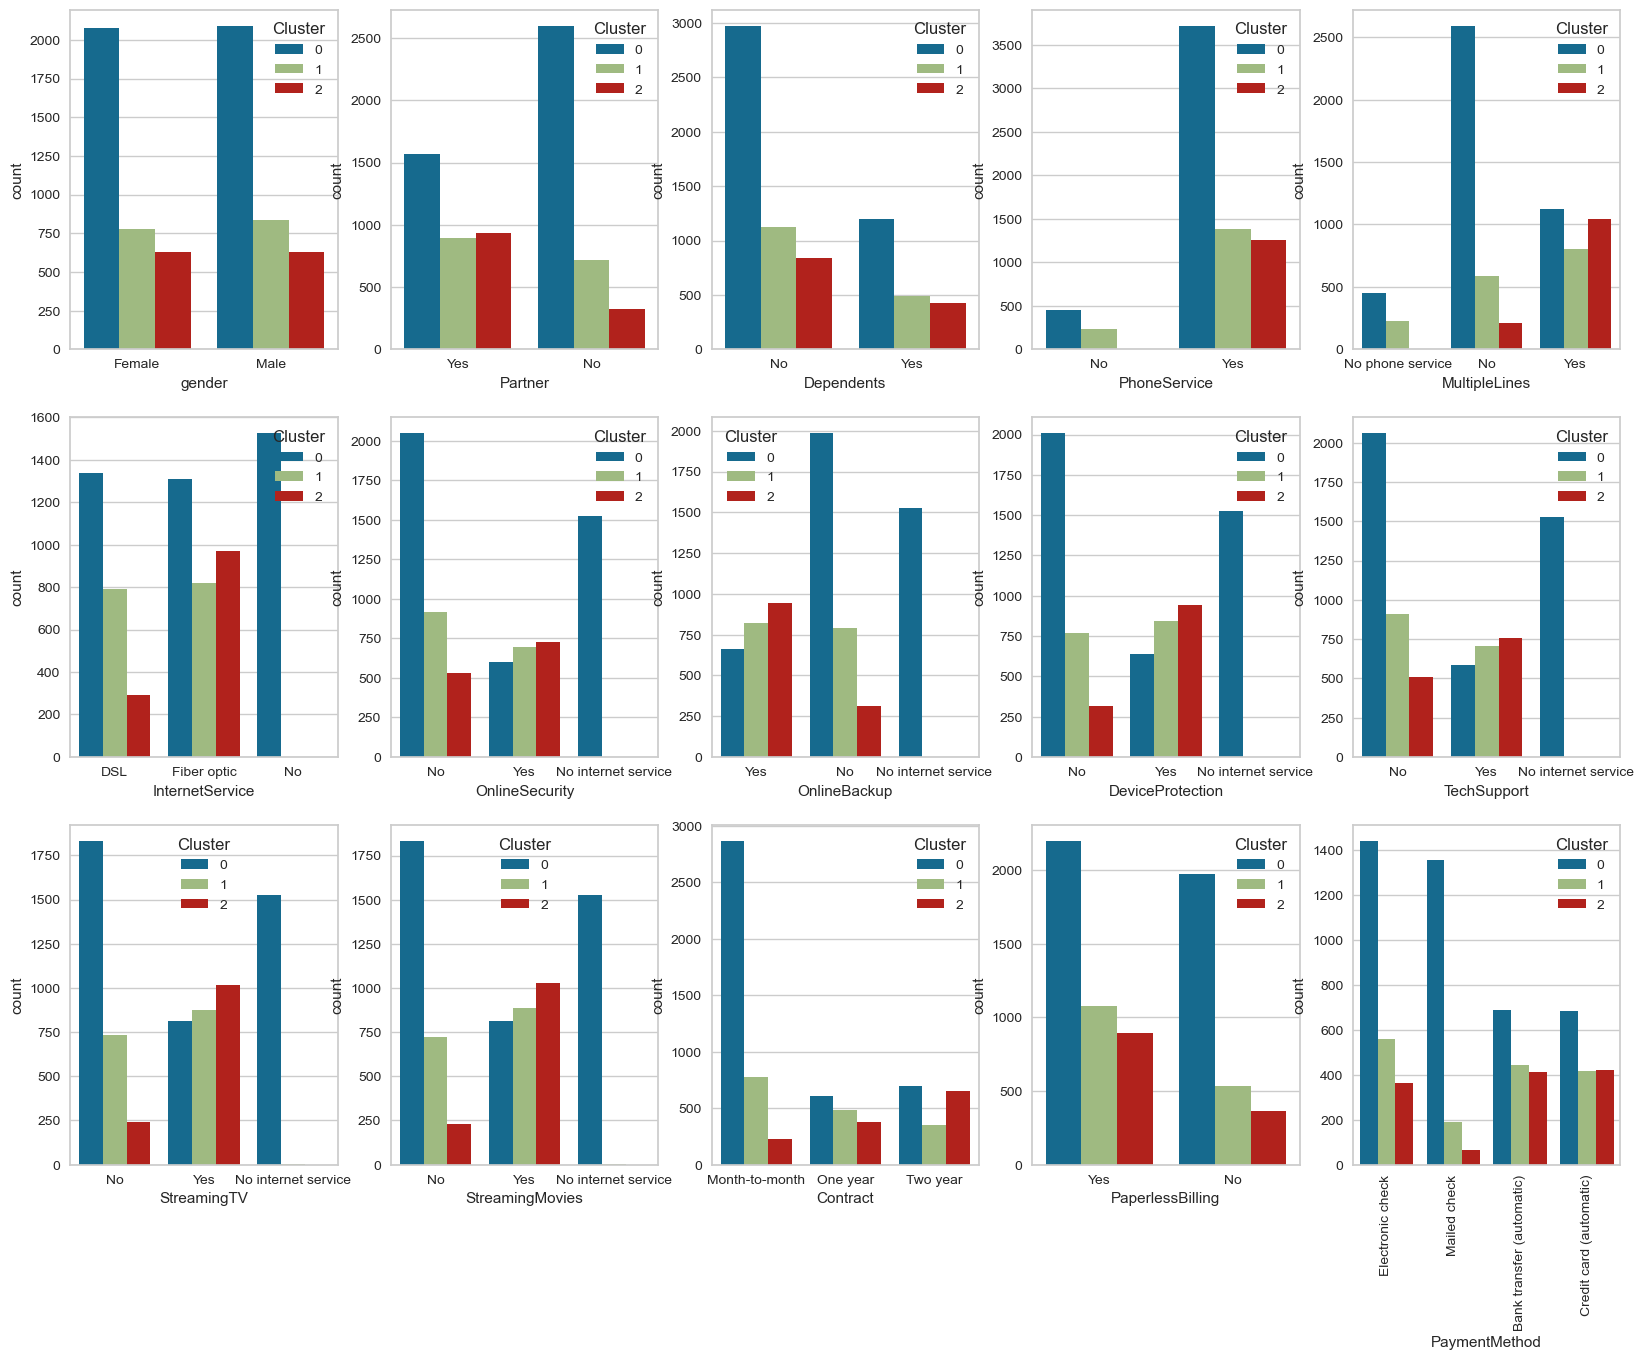

In [89]:
fig, ax = plt.subplots(3, 5, figsize=(20, 15))
ax = ax.ravel()

for j, col in enumerate(cluster.select_dtypes(include='object').columns):
    if col != 'Churn':
     sns.countplot(x = col, ax = ax[j], data = df, hue = "Cluster", hue_order=['0', '1', '2'])
    if j == 14:
        ax[j].set_xticklabels(ax[j].get_xticklabels(), rotation=90)
plt.show()

C:\Users\WIN-10\AppData\Local\Temp\ipykernel_19988\2162403695.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i][j].set_xticklabels(ax[i][j].get_xticklabels(), rotation=90)
C:\Users\WIN-10\AppData\Local\Temp\ipykernel_19988\2162403695.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i][j].set_xticklabels(ax[i][j].get_xticklabels(), rotation=90)
C:\Users\WIN-10\AppData\Local\Temp\ipykernel_19988\2162403695.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i][j].set_xticklabels(ax[i][j].get_xticklabels(), rotation=90)


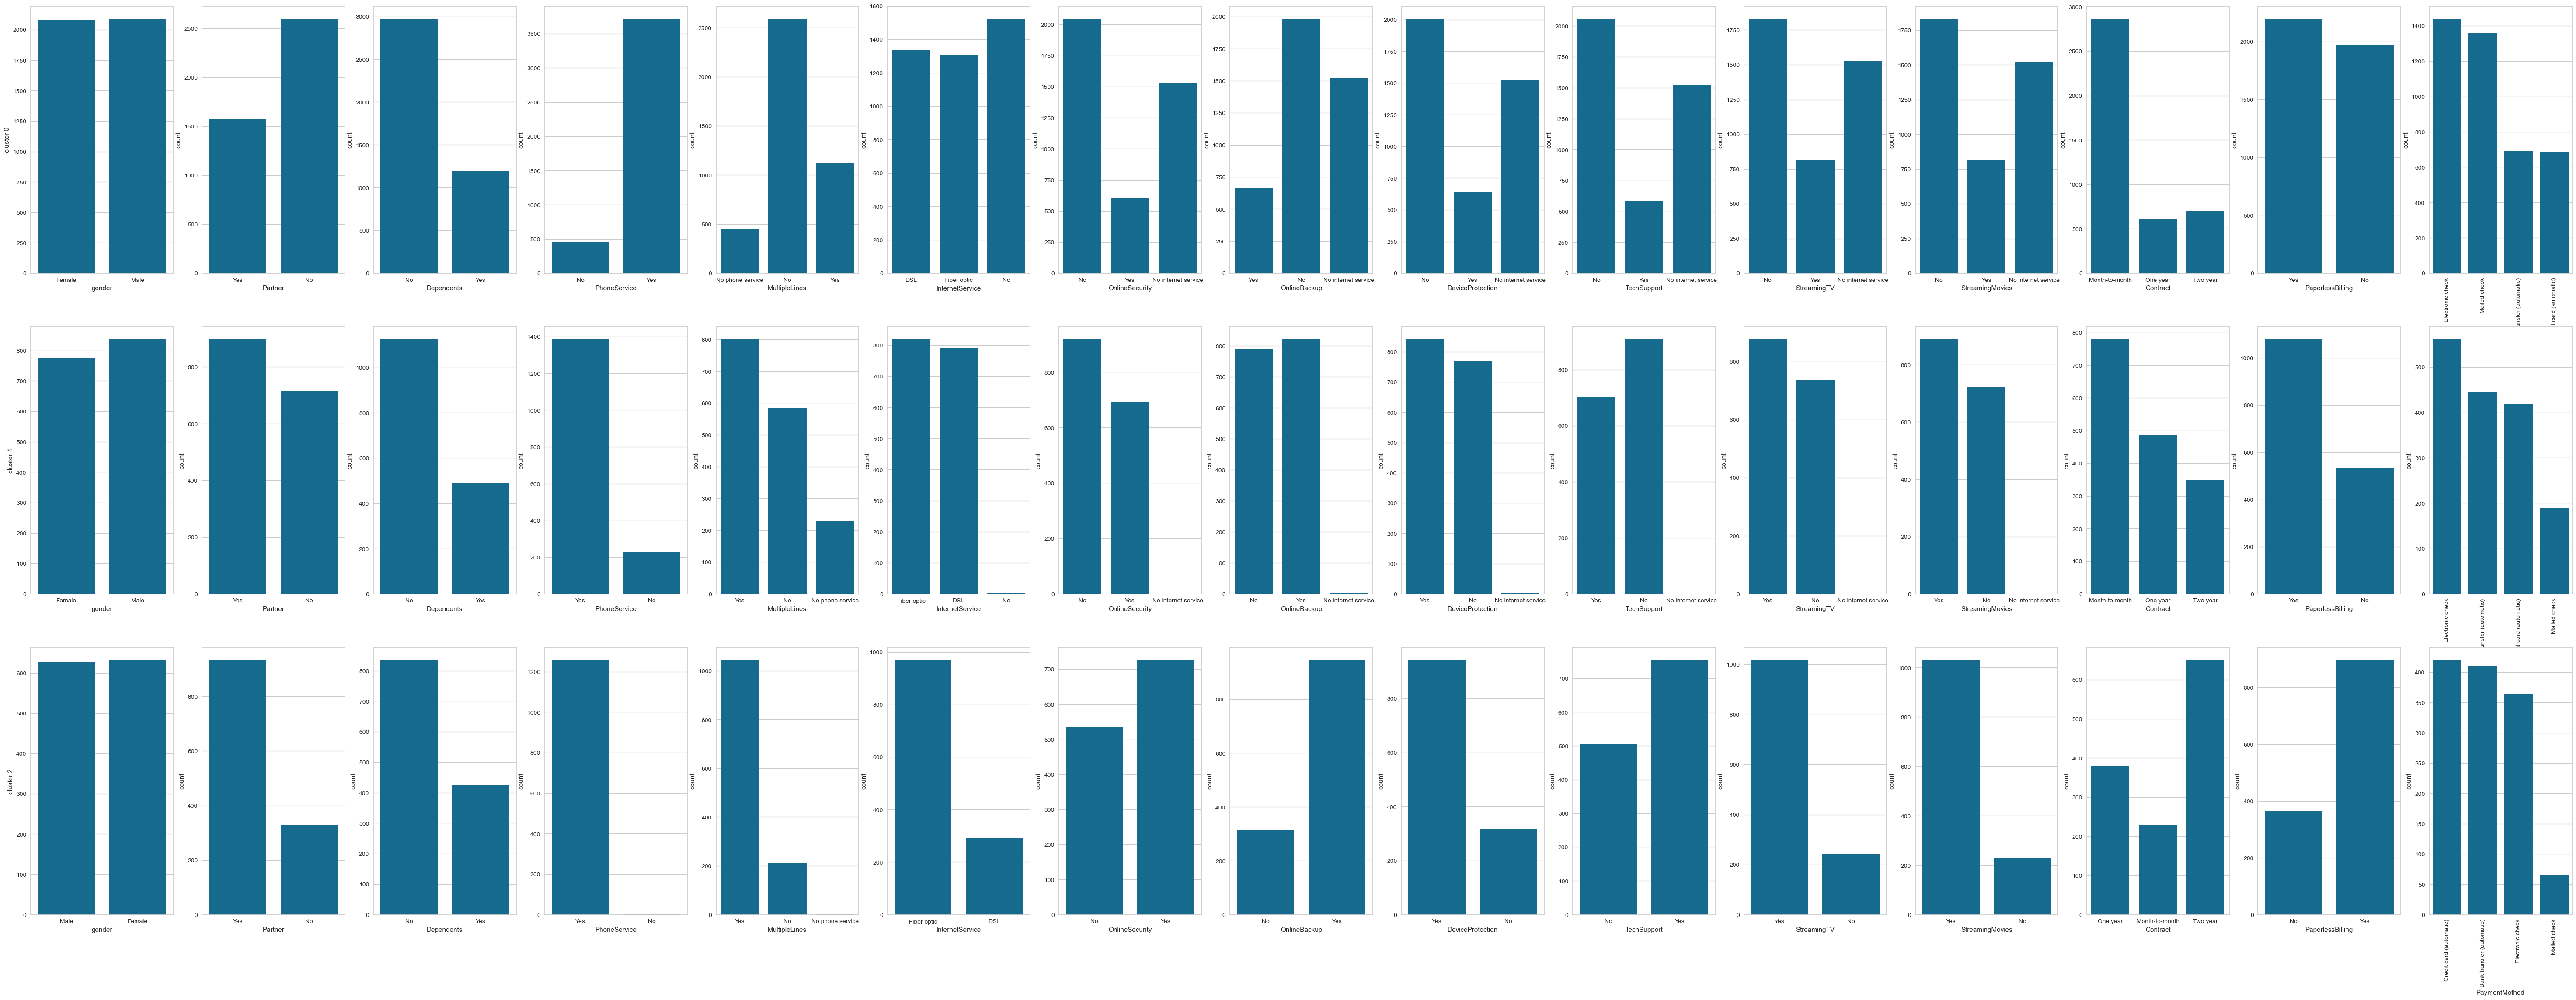

In [90]:
fig, ax = plt.subplots(3, 15, figsize=(75, 27))

for i, cluster in enumerate(clusters):
  ax[i][0].set_ylabel(f"cluster {i}")
  for j, col in enumerate(cluster.select_dtypes(include='object').columns):
    if col != 'Churn':
      sns.countplot(x = col, ax = ax[i][j], data = cluster)
      if j == 14:
        ax[i][j].set_xticklabels(ax[i][j].get_xticklabels(), rotation=90)
plt.show()

### Agglomerative Clustering algorithm

In [91]:
from sklearn.cluster import AgglomerativeClustering

In [92]:
agglom = AgglomerativeClustering(n_clusters = 3, linkage = 'complete').fit(data_pca)
clusters = agglom.labels_

In [93]:
clusters = map_clusters(clusters)

In [94]:
silhouette_avg = silhouette_score(data_pca, clusters)
print(silhouette_avg)

0.6528055030352181


In [95]:
df["Cluster"] = clusters

In [96]:
dist = distance_matrix(data_pca, data_pca)

C:\Users\WIN-10\AppData\Local\Temp\ipykernel_19988\3271043637.py:1: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = hierarchy.linkage(dist, 'complete')


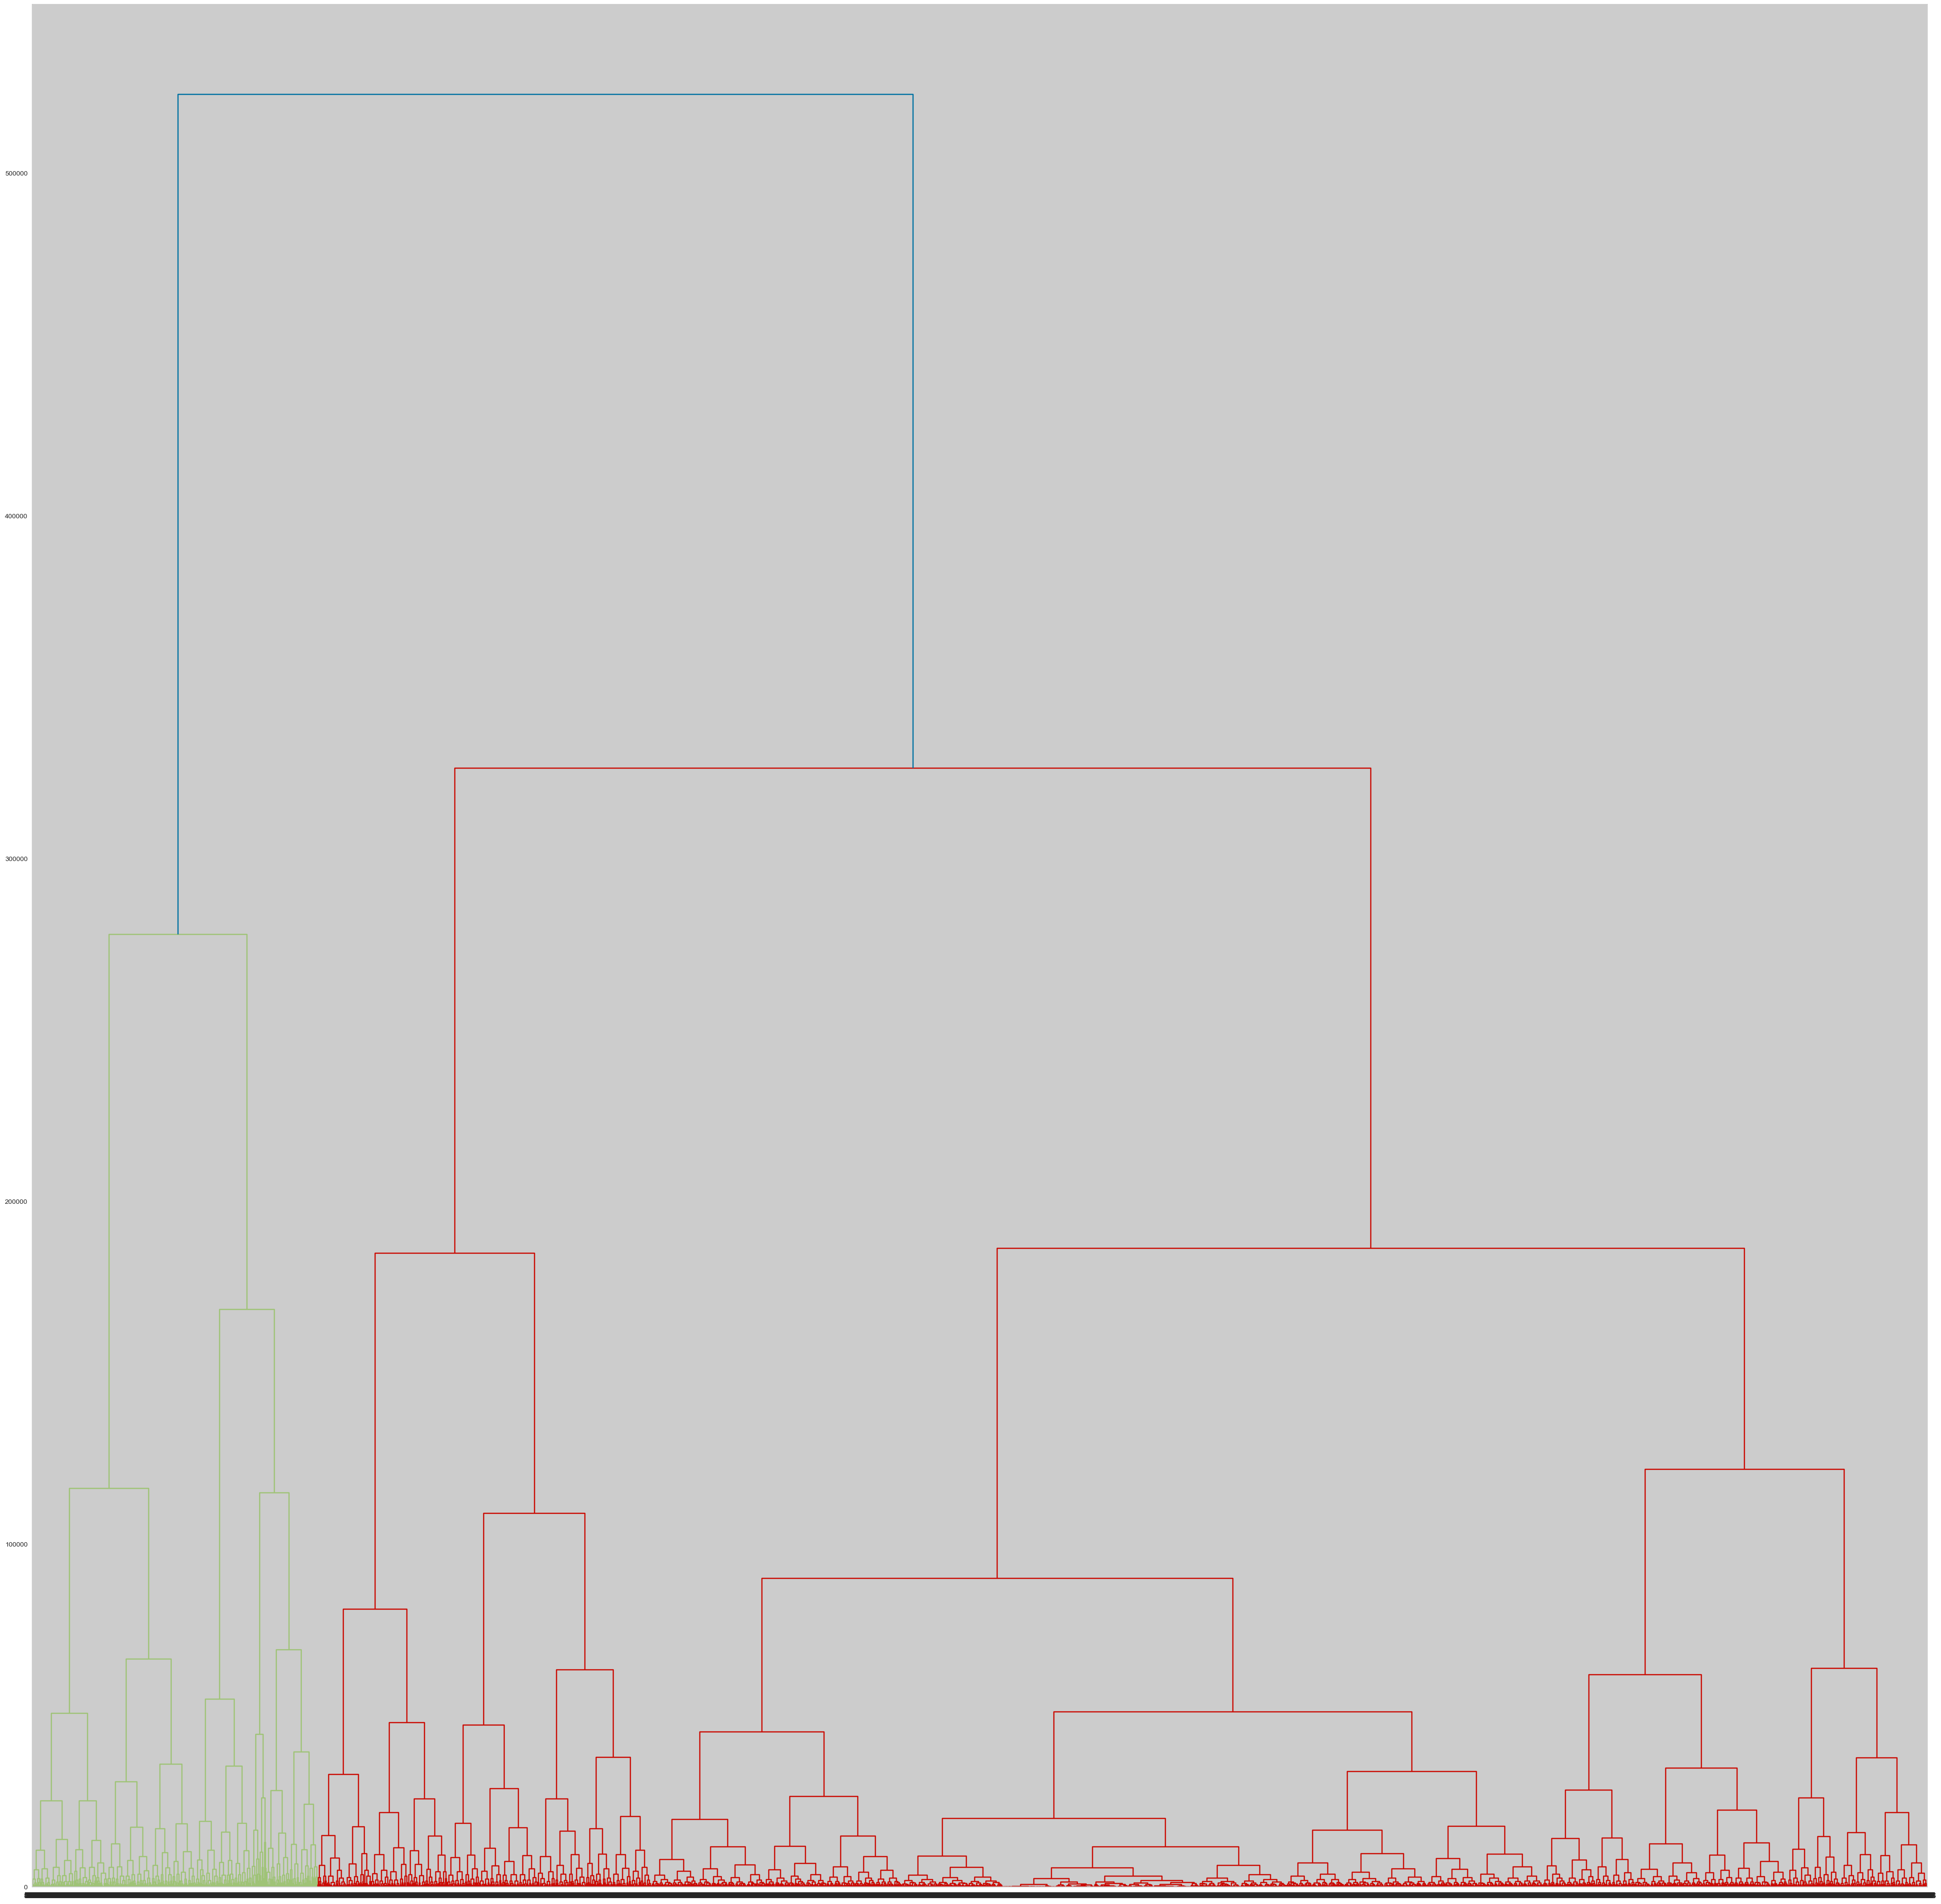

In [97]:
Z = hierarchy.linkage(dist, 'complete')
plt.figure(figsize = (50, 50))
dendro = hierarchy.dendrogram(Z, leaf_rotation = 0, leaf_font_size = 12, orientation = 'top')

C:\Users\WIN-10\AppData\Local\Temp\ipykernel_19988\2340340163.py:1: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = hierarchy.linkage(dist, 'average')


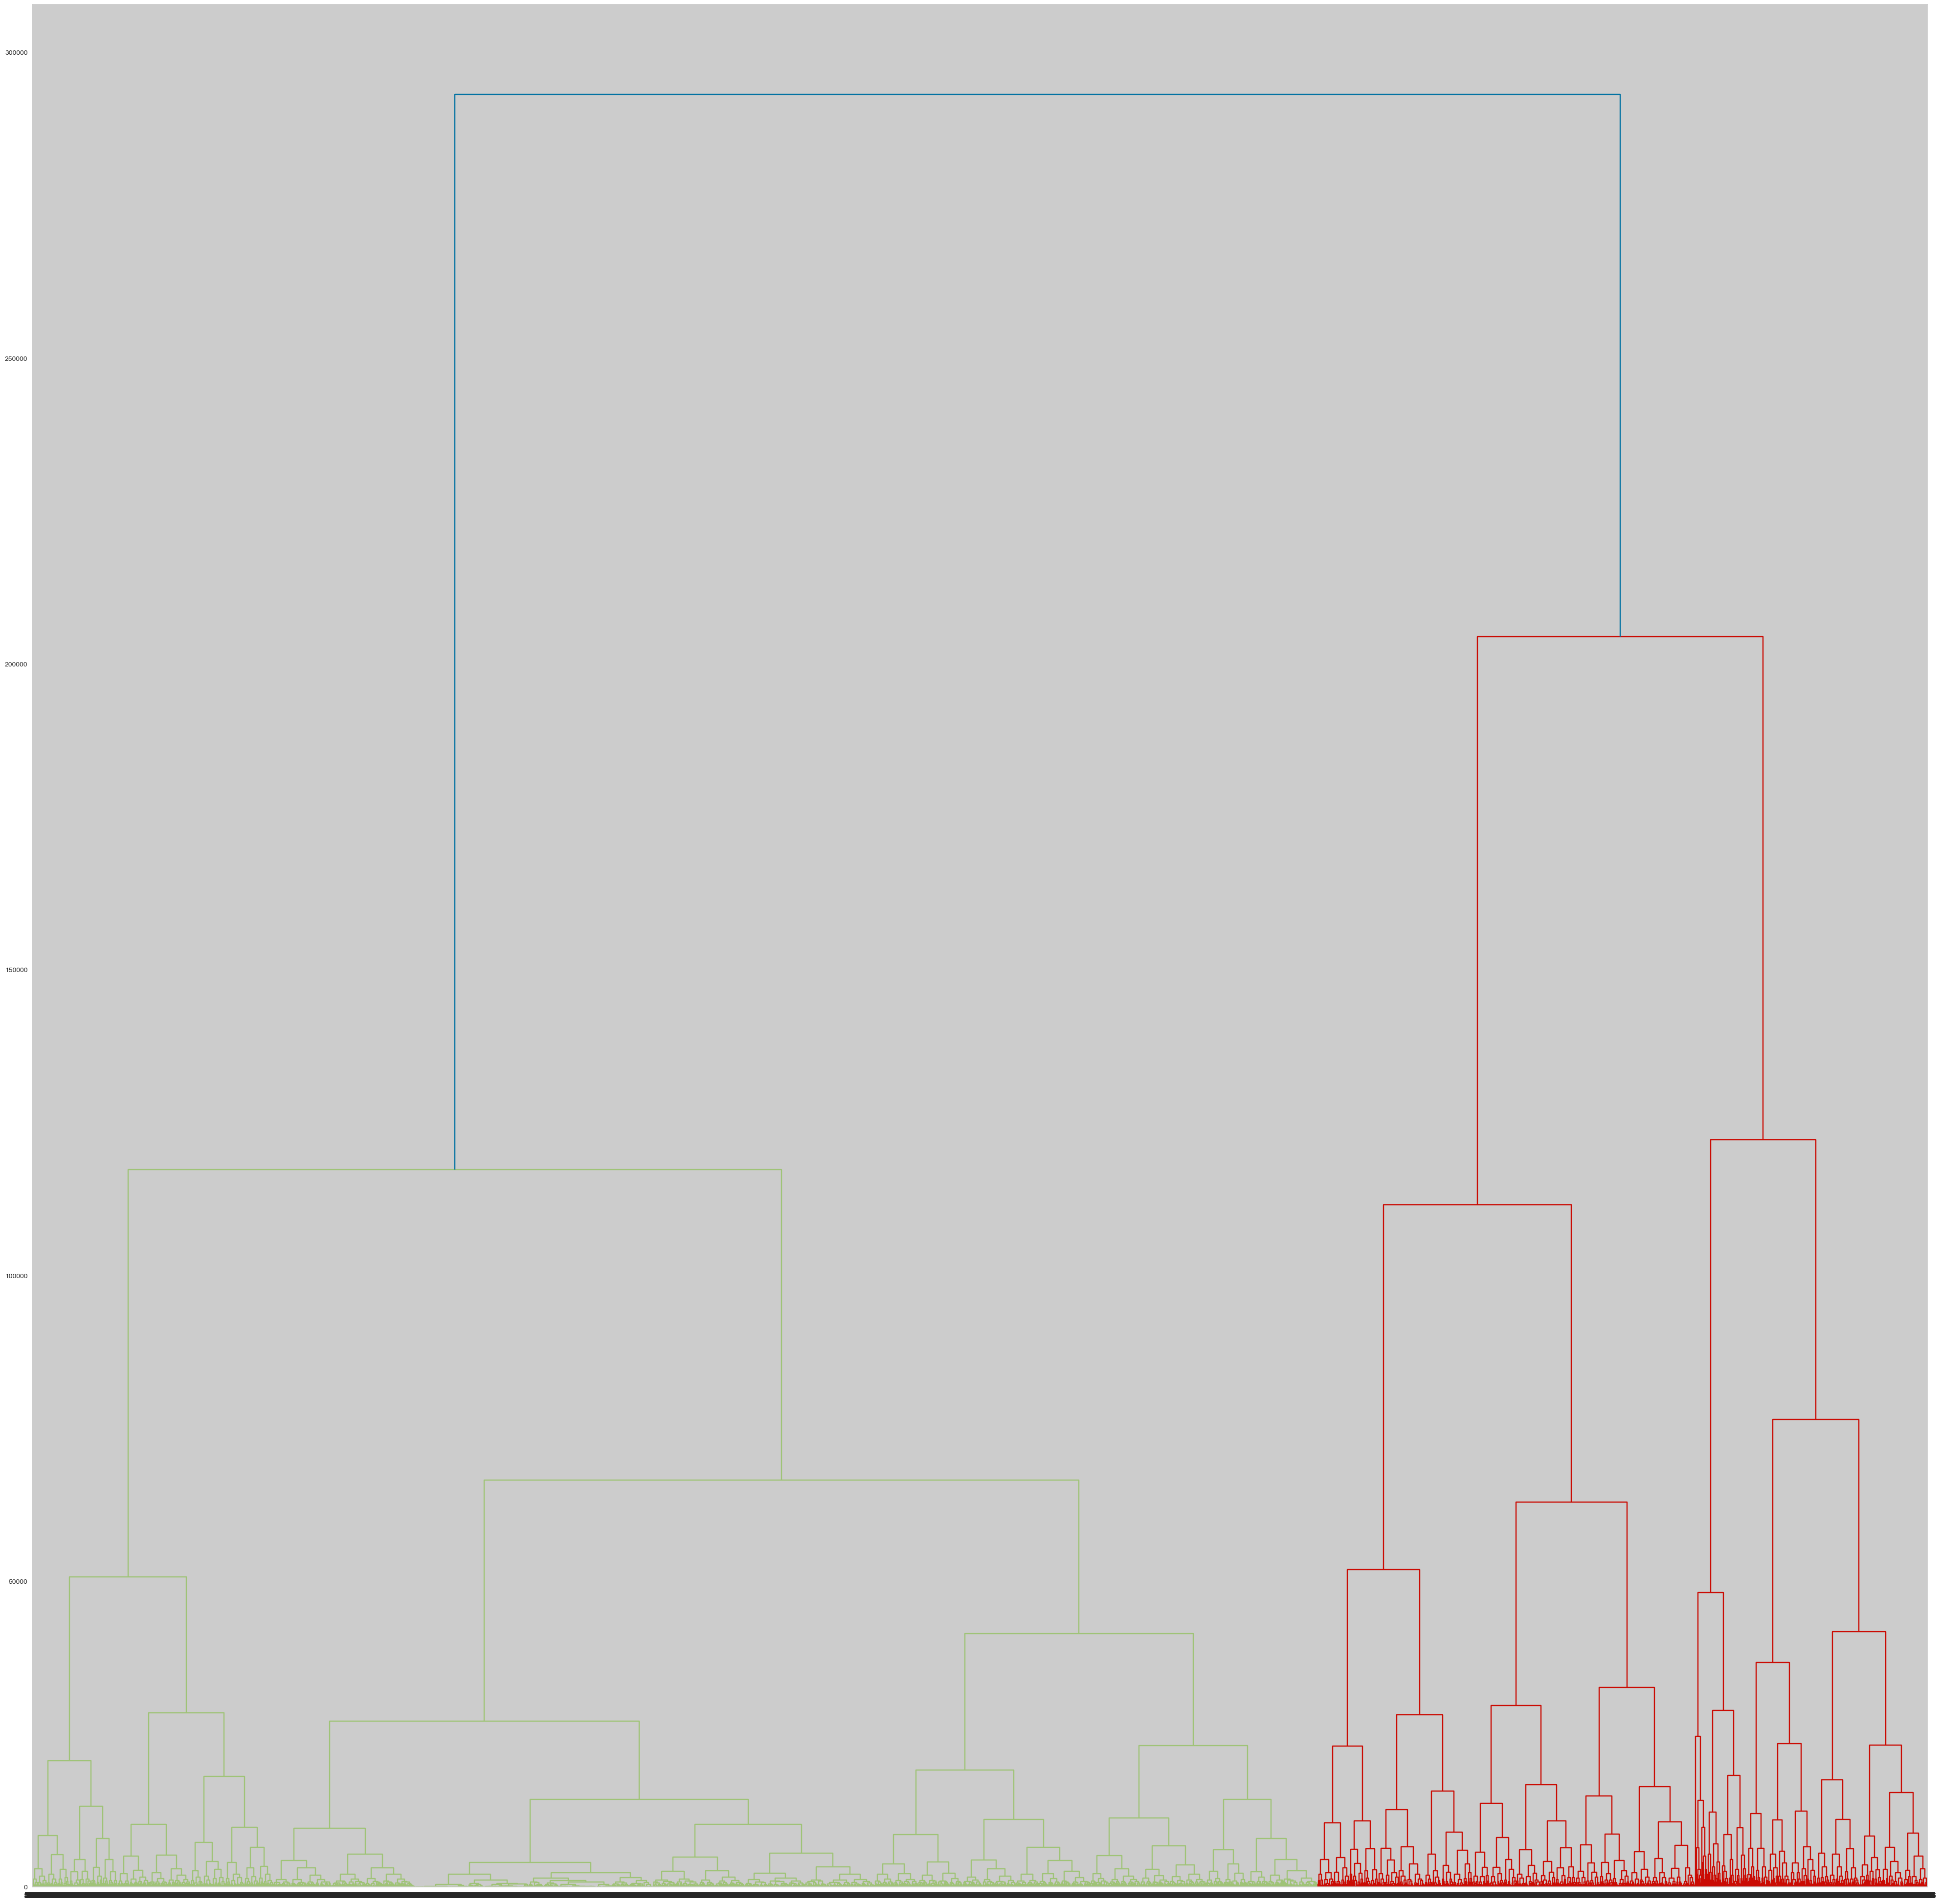

In [98]:
Z = hierarchy.linkage(dist, 'average')
plt.figure(figsize = (50, 50))
dendro = hierarchy.dendrogram(Z, leaf_rotation = 0, leaf_font_size = 12, orientation = 'top')

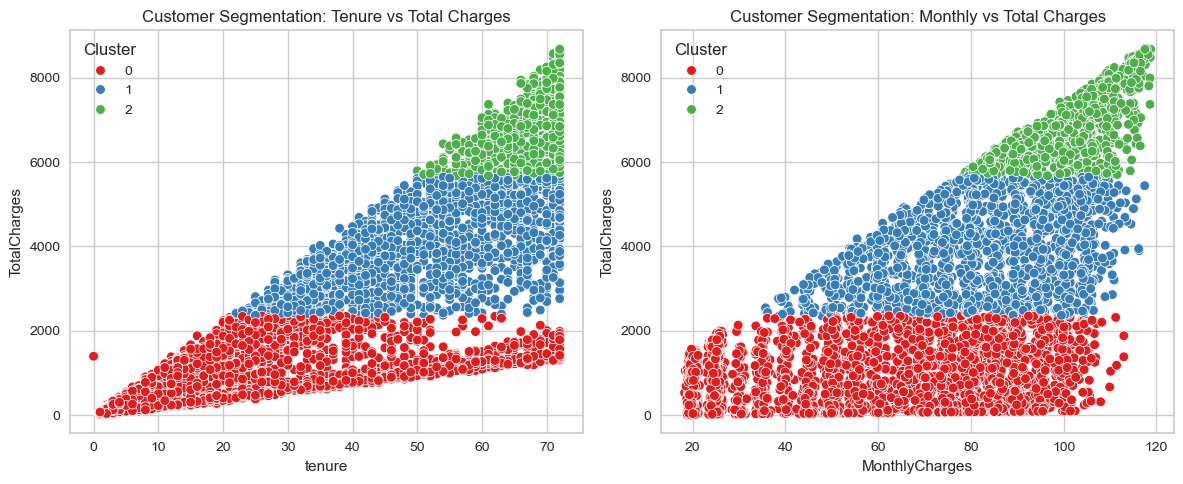

In [99]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns
axes = axes.ravel()

# Plot tenure vs TotalCharges
sns.scatterplot(x='tenure', y='TotalCharges', data=df, hue='Cluster', palette='Set1', ax=axes[0])
axes[0].set_title('Customer Segmentation: Tenure vs Total Charges')

# Plot MonthlyCharges vs TotalCharges
sns.scatterplot(x='MonthlyCharges', y='TotalCharges', data=df, hue='Cluster', palette='Set1', ax=axes[1])
axes[1].set_title('Customer Segmentation: Monthly vs Total Charges')

# Display the plots
plt.tight_layout()
plt.show()

In [100]:
cluster1 = df[df["Cluster"] == 0]
cluster2 = df[df["Cluster"] == 1]
cluster3 = df[df["Cluster"] == 2]
clusters = [cluster1, cluster2, cluster3]

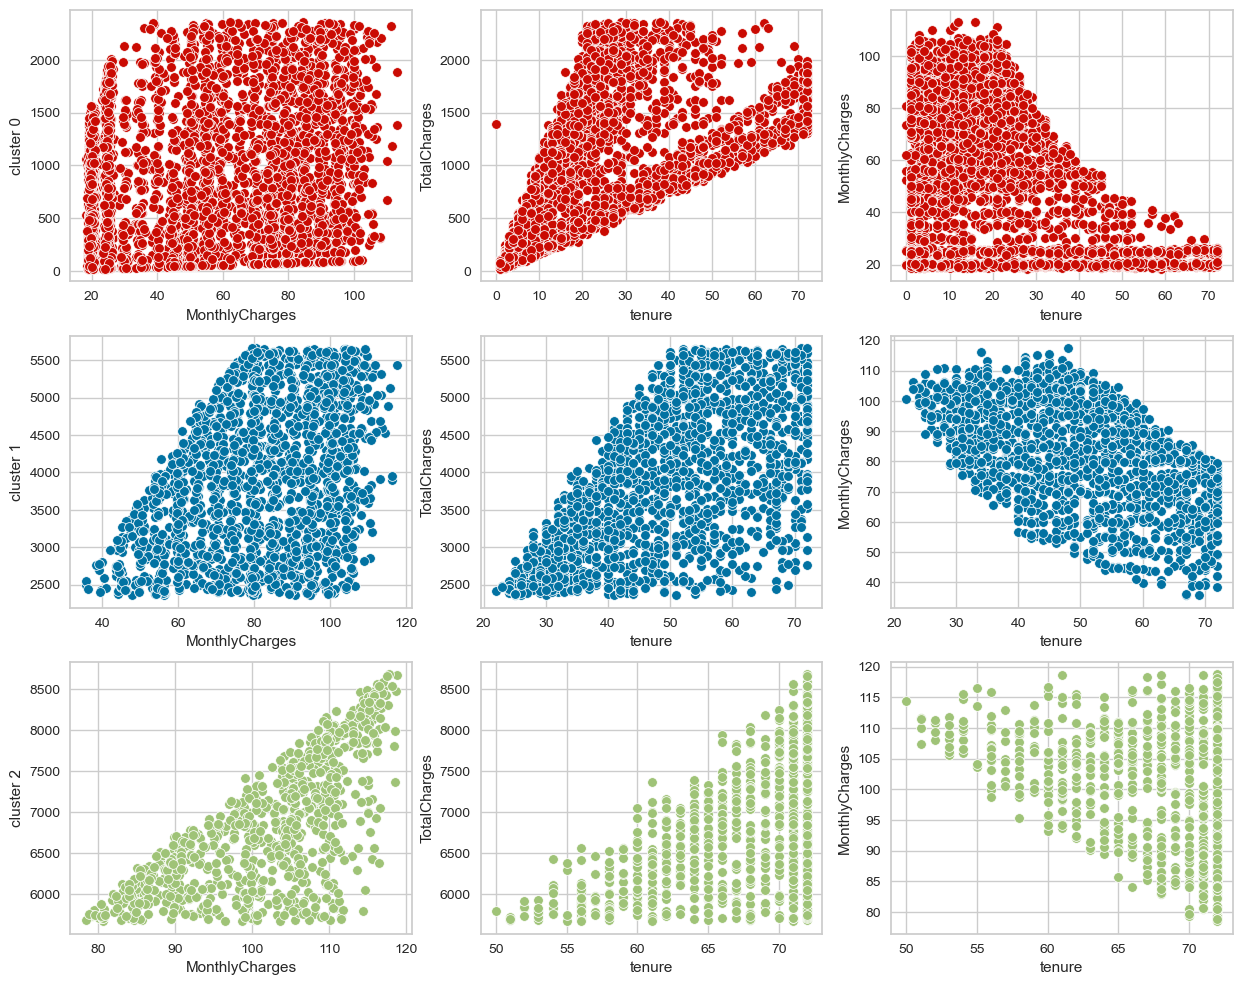

In [101]:
fig, ax = plt.subplots(3, 3, figsize = (15, 12))
colors = ['r', 'b', 'g']

for i, cluster in enumerate(clusters):
  ax[i][0].set_ylabel(f"cluster {i}")
  sns.scatterplot(x = "MonthlyCharges", y = "TotalCharges", data = cluster, ax = ax[i][0], color=colors[i])
  sns.scatterplot(x = "tenure", y = "TotalCharges", data = cluster, ax = ax[i][1], color = colors[i])
  sns.scatterplot(x = "tenure", y = "MonthlyCharges", data = cluster, ax = ax[i][2], color = colors[i])
plt.show()

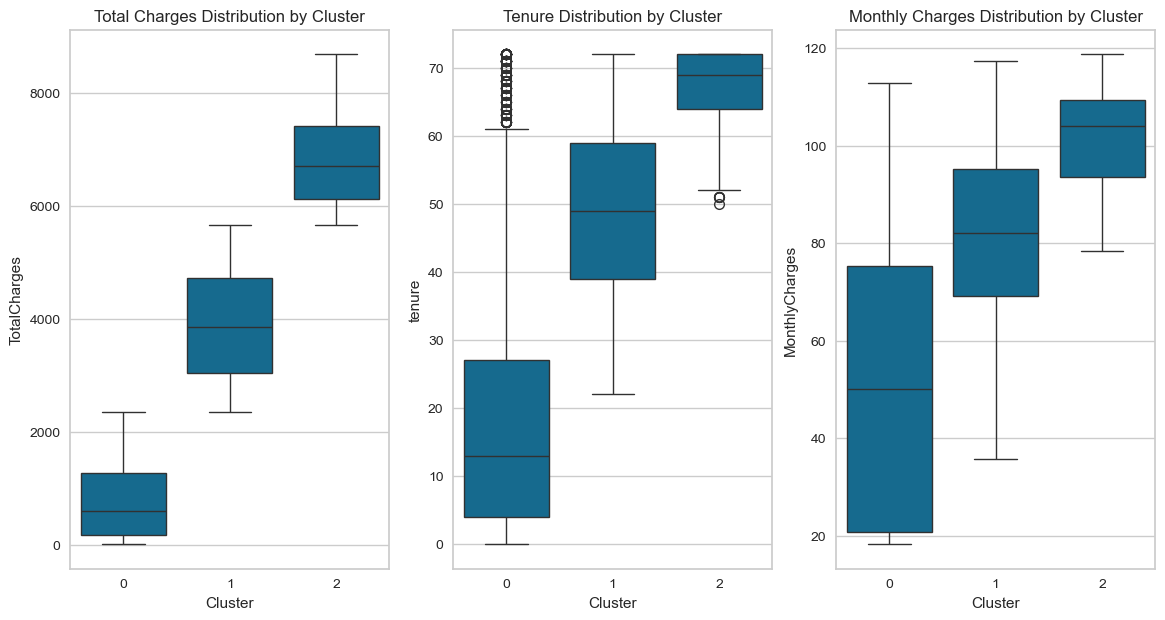

In [102]:
fig, axs = plt.subplots(1, 3, figsize=(14, 7))
sns.boxplot(x='Cluster', y = "TotalCharges", data=df, ax=axs[0]).set_title('Total Charges Distribution by Cluster')
sns.boxplot(x='Cluster', y='tenure', data=df, ax=axs[1]).set_title('Tenure Distribution by Cluster')
sns.boxplot(x='Cluster', y='MonthlyCharges', data=df, ax=axs[2]).set_title('Monthly Charges Distribution by Cluster')
plt.show()

In [103]:
df['Cluster'] = df['Cluster'].astype('str')

C:\Users\WIN-10\AppData\Local\Temp\ipykernel_19988\3989707512.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[j].set_xticklabels(ax[j].get_xticklabels(), rotation=90)


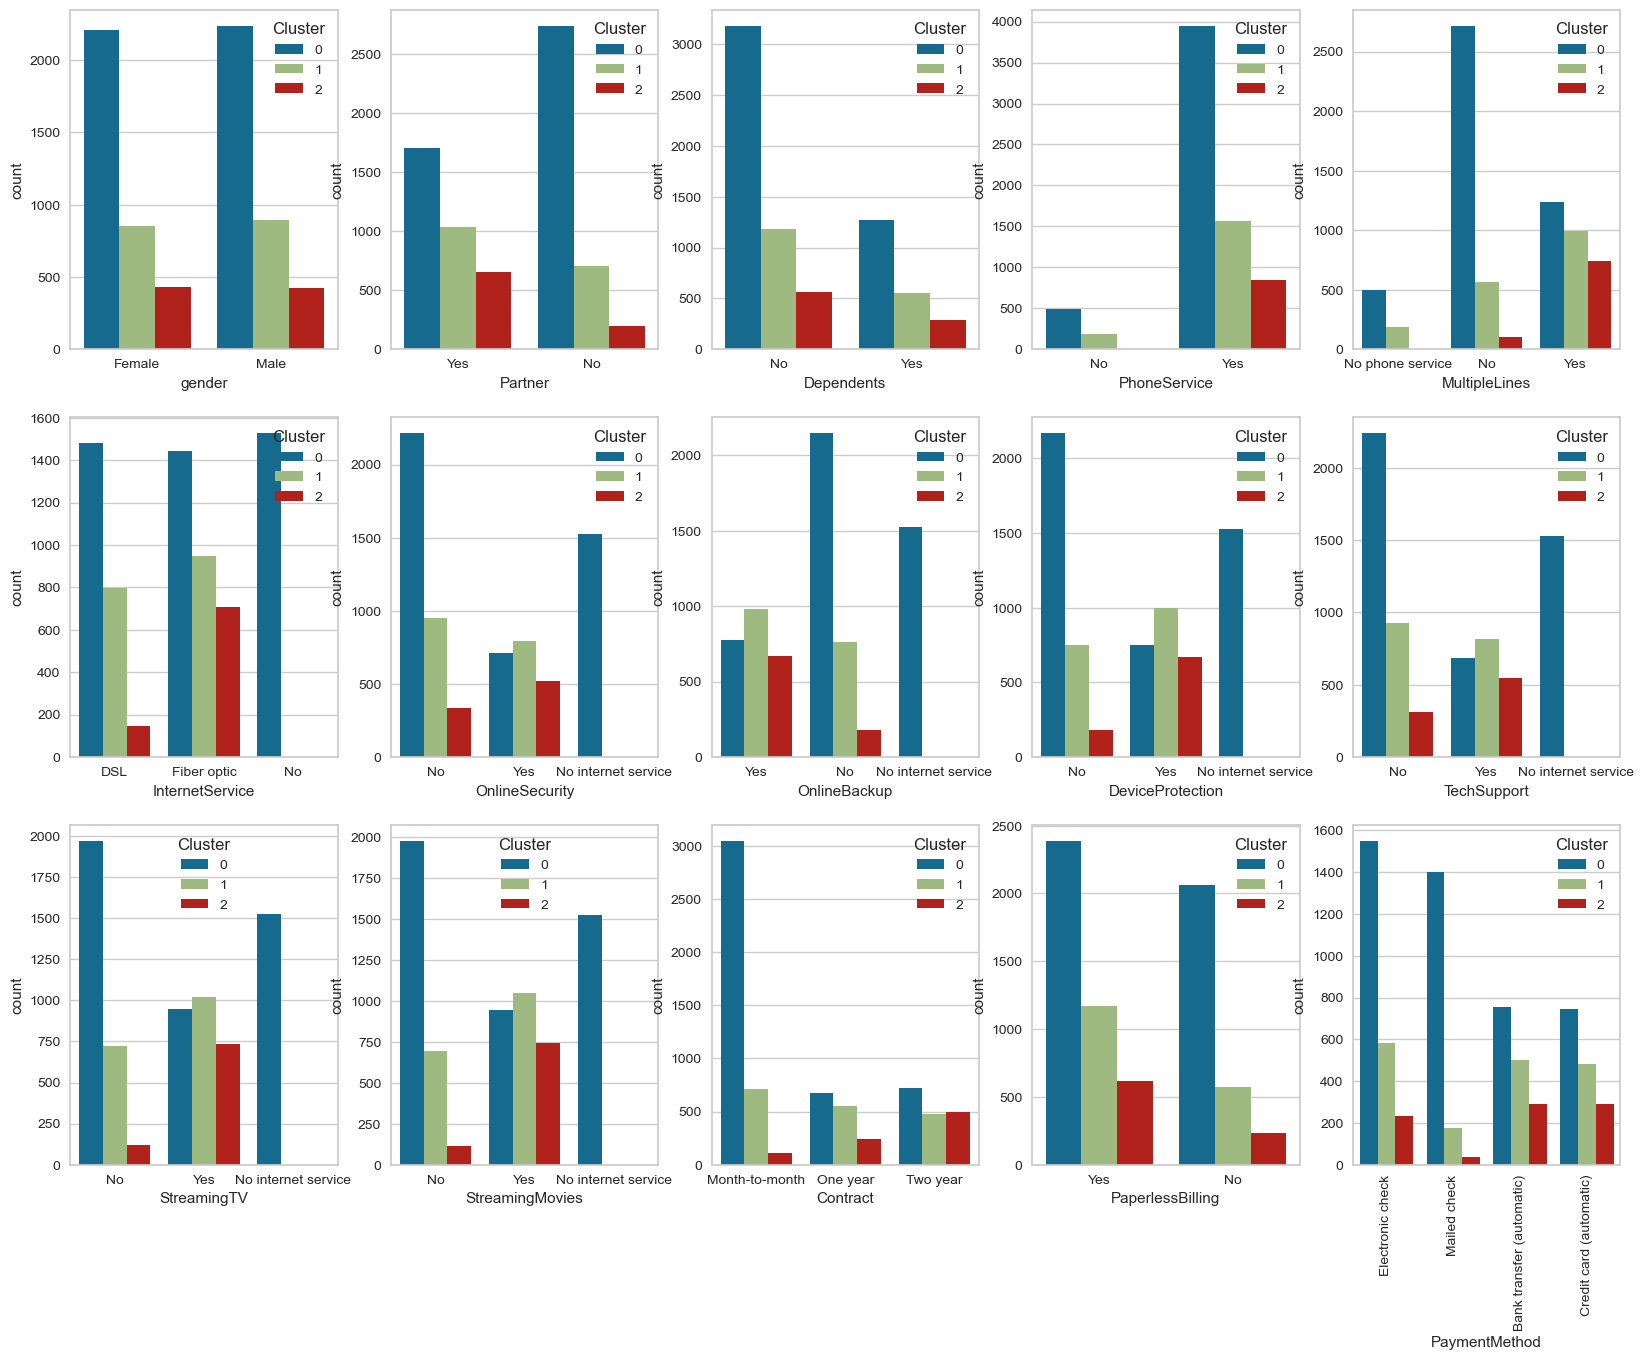

In [104]:
fig, ax = plt.subplots(3, 5, figsize=(20, 15))
ax = ax.ravel()

for j, col in enumerate(cluster.select_dtypes(include='object').columns):
    if col != 'Churn':
     sns.countplot(x = col, ax = ax[j], data = df, hue = "Cluster", hue_order=['0', '1', '2'])
    if j == 14:
        ax[j].set_xticklabels(ax[j].get_xticklabels(), rotation=90)
plt.show()

C:\Users\WIN-10\AppData\Local\Temp\ipykernel_19988\2162403695.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i][j].set_xticklabels(ax[i][j].get_xticklabels(), rotation=90)
C:\Users\WIN-10\AppData\Local\Temp\ipykernel_19988\2162403695.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i][j].set_xticklabels(ax[i][j].get_xticklabels(), rotation=90)
C:\Users\WIN-10\AppData\Local\Temp\ipykernel_19988\2162403695.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i][j].set_xticklabels(ax[i][j].get_xticklabels(), rotation=90)


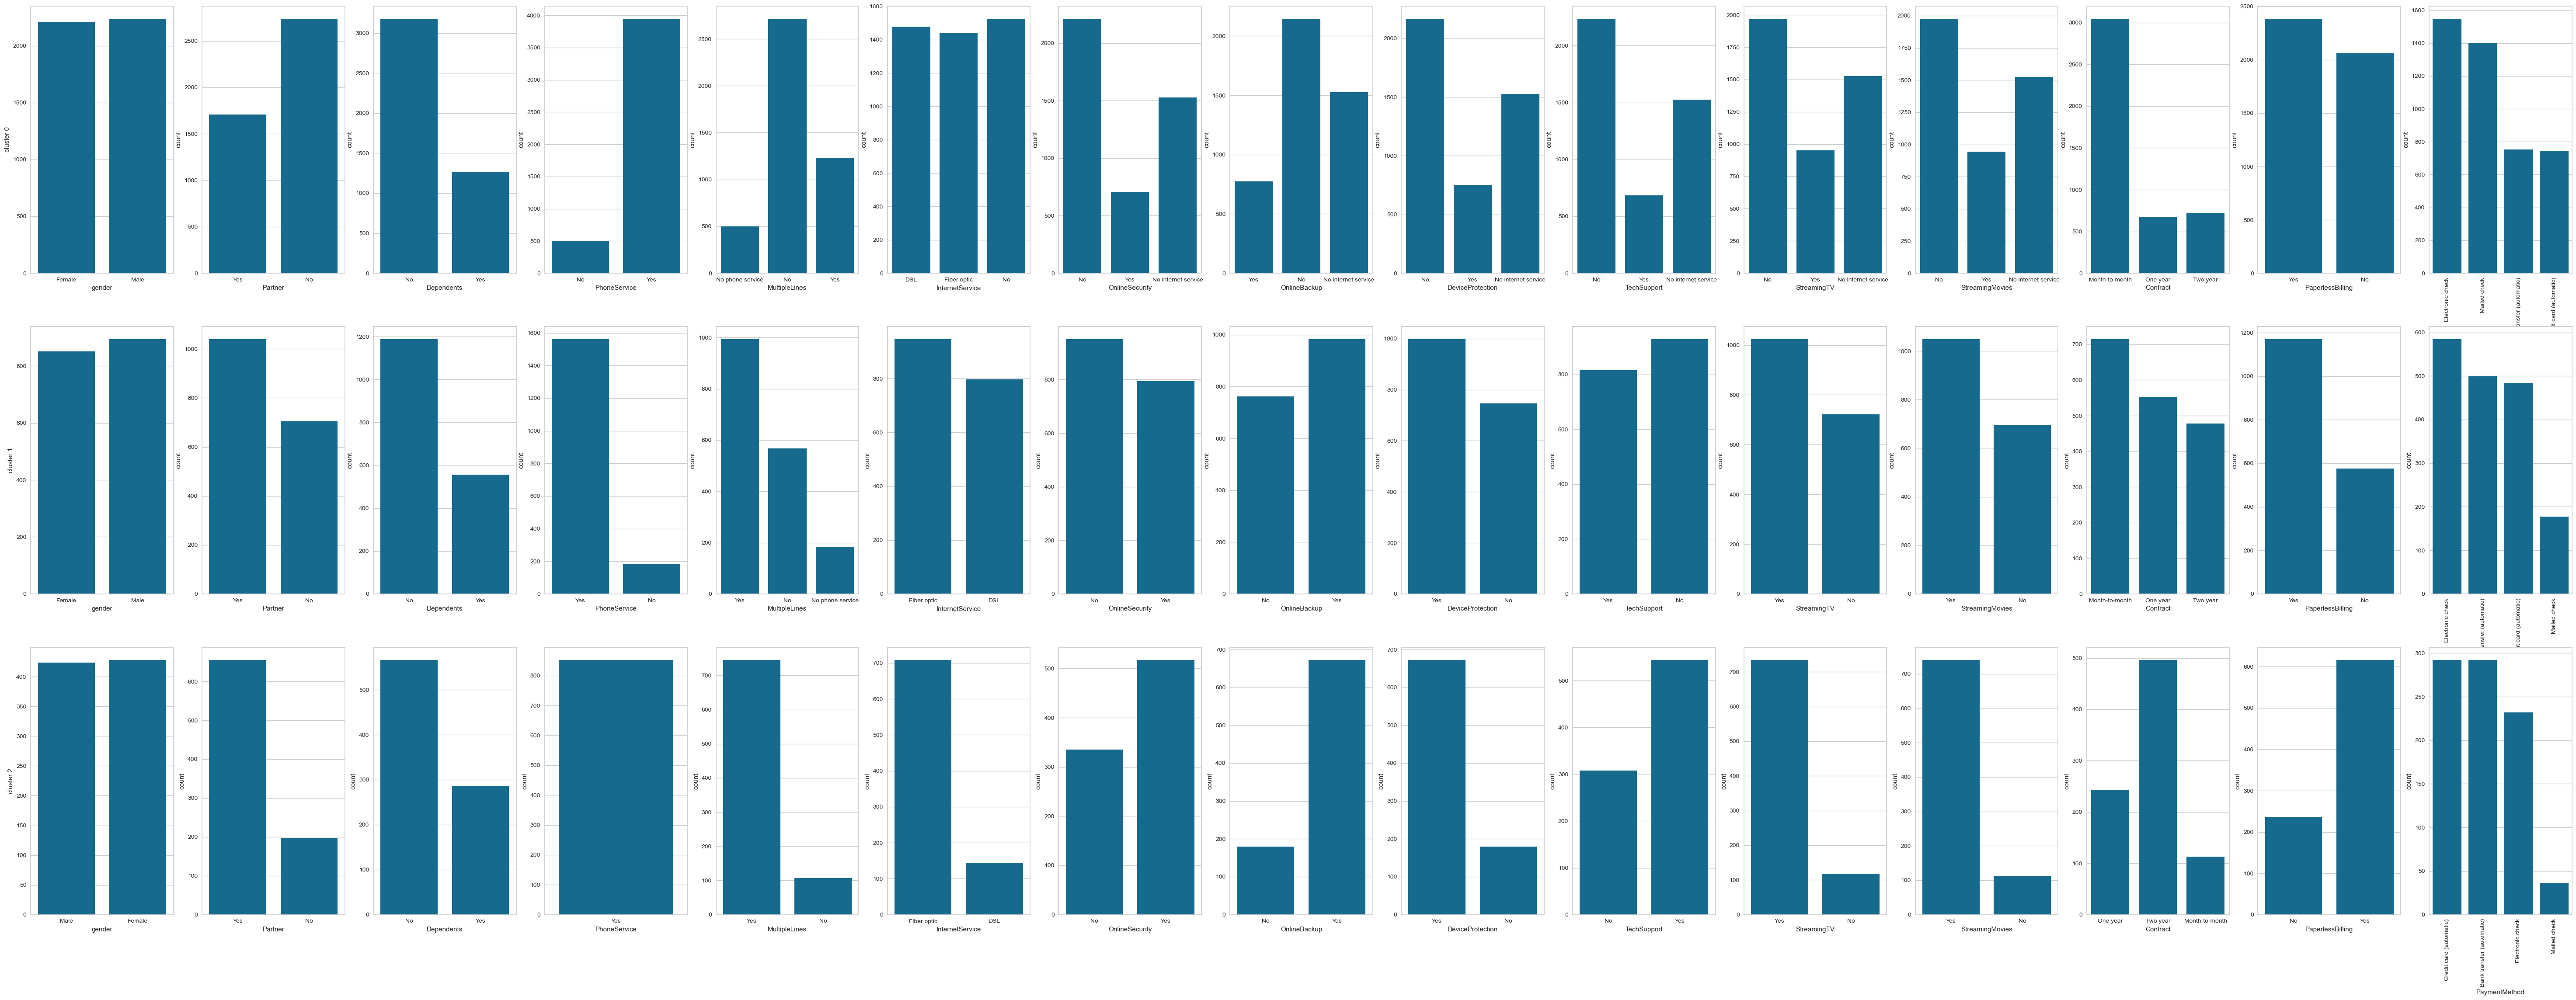

In [105]:
fig, ax = plt.subplots(3, 15, figsize=(75, 27))

for i, cluster in enumerate(clusters):
  ax[i][0].set_ylabel(f"cluster {i}")
  for j, col in enumerate(cluster.select_dtypes(include='object').columns):
    if col != 'Churn':
      sns.countplot(x = col, ax = ax[i][j], data = cluster)
      if j == 14:
        ax[i][j].set_xticklabels(ax[i][j].get_xticklabels(), rotation=90)
plt.show()

## GUI

In [106]:
import tkinter as tk
from tkinter import messagebox
import pandas as pd

In [107]:
columns = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
           'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
           'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
           'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
           'MonthlyCharges', 'TotalCharges']

In [108]:
df_prediction = df_prediction.drop(["Churn", "PhoneService", "gender"], axis=1)
df_encode = df_prediction
df_prediction = df_prediction.drop(df_prediction.index)
print(df_prediction.columns)

Index(['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges'],
      dtype='object')


In [109]:
from scipy.spatial.distance import cdist
def clustering():
    # Get values
    values = {col: entry_fields[col].get() for col in columns}
    for col, value in values.items():
        if value == "":
            messagebox.showerror("Input Error", f"Please fill in the {col} field.")
            return  


    
    #predict_data = predict_data.drop("Churn", axis=1)

    clasfy = {  
    'SeniorCitizen': int(values['SeniorCitizen']),
    'Partner':values['Partner'],  
    'Dependents':values['Dependents'],
    'tenure':int(values['tenure']),    
    'MultipleLines':values['MultipleLines'],
    'InternetService':values['InternetService'],
    'OnlineSecurity':values['OnlineSecurity'],
    'OnlineBackup':values['OnlineBackup'],  
    'DeviceProtection':values['DeviceProtection'],    
    'TechSupport':values['TechSupport'],
    'StreamingTV':values['StreamingTV'],
    'StreamingMovies':values['StreamingMovies'],
    'Contract':values['Contract'],    
    'PaperlessBilling':values['PaperlessBilling'],
    'PaymentMethod':values['PaymentMethod'],
    'MonthlyCharges': float(values['MonthlyCharges']),
    'TotalCharges': float(values['TotalCharges'])
    }
    
    input_data = df_prediction.copy() 
    input_data.loc[0] = clasfy
    #for col in categorical_columns:
    #for col in input_data.select_dtypes(include='object').columns:
     #   if col in enc_col_label_cluster:
      #      input_data[col] = input_data[col].map({x: i for i, x in enumerate(enc_col_label_cluster[col])})
    for col in input_data.select_dtypes(include='object').columns:
        if col in enc_col_label_cluster:
            input_data[col] = input_data[col].map({x: i for i, x in enumerate(enc_col_label_cluster[col])})    
    #for col in categorical_columns:
        #if col in input_data.columns: 
            #input_data[col] = label_encoder.transform(input_data[col])
  
    pca_data = pca.transform(input_data)

    selected_algo = algo_var1.get() 
    if selected_algo == "hierarchical":
        cluster_centers = np.array([X_pca[agglom.labels_ == i].mean(axis=0) for i in range(optimal_clusters)])
        t1 = cluster_centers
        distances = cdist(pca_data, cluster_centers)
        
        prediction = np.argmin(distances, axis=1)
    elif selected_algo == "K-mean":
        prediction = km3.predict(pca_data) 
    if prediction == 0:
        messagebox.showinfo("Result", ' is segment ["Mid-tier Customer"].')
    elif prediction == 1:
        messagebox.showinfo("Result", ' is segment ["High spenders"]')
    elif prediction == 2: 
        messagebox.showinfo("Result", ' is segment ["Budget-conscious"]')
    else:
        messagebox.showerror("Error.")
        return  

In [110]:
import tkinter as tk

root = tk.Tk()
root.title("Predict Customer Segmentation")



# Categorical values
categorical_columns = {
    'gender': ['Female', 'Male'],
    'Partner': ['Yes', 'No'],
    'Dependents': ['No', 'Yes'],
    'PhoneService': ['No', 'Yes'],
    'MultipleLines': ['No phone service', 'No', 'Yes'],
    'InternetService': ['DSL', 'Fiber optic', 'No'],
    'OnlineSecurity': ['No', 'Yes', 'No internet service'],
    'OnlineBackup': ['Yes', 'No', 'No internet service'],
    'DeviceProtection': ['No', 'Yes', 'No internet service'],
    'TechSupport': ['No', 'Yes', 'No internet service'],
    'StreamingTV': ['No', 'Yes', 'No internet service'],
    'StreamingMovies': ['No', 'Yes', 'No internet service'],
    'Contract': ['Month-to-month', 'One year', 'Two year'],
    'PaperlessBilling': ['Yes', 'No'],
    'PaymentMethod': ['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)']
}


numerical_columns = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

entry_fields = {}

def create_dropdown(label_text, options, row, col):
    label = tk.Label(root, text=label_text)
    label.grid(row=row, column=col, padx=10, pady=5, sticky="e")
    
    var = tk.StringVar(root)
    var.set(options[0])  # Default
    dropdown = tk.OptionMenu(root, var, *options)
    dropdown.grid(row=row, column=col+1, padx=10, pady=5, sticky="w")
    
    entry_fields[label_text] = var  


row_offset = 0
halfway_point = len(categorical_columns) // 2

for i, col in enumerate(list(categorical_columns)[:halfway_point]):
    create_dropdown(col, categorical_columns[col], i + row_offset, 0)


for i, col in enumerate(list(categorical_columns)[halfway_point:]):
    create_dropdown(col, categorical_columns[col], i + row_offset, 2)

def create_entry(label_text, row, col):
    label = tk.Label(root, text=label_text)
    label.grid(row=row, column=col, padx=10, pady=5, sticky="e")
    entry = tk.Entry(root)
    entry.grid(row=row, column=col+1, padx=10, pady=5, sticky="w")
    entry_fields[label_text] = entry  # Store entry for later use


row_offset = halfway_point + 1  
halfway_point = len(numerical_columns) // 2
for i, col in enumerate(list(numerical_columns)[:halfway_point]):
    create_entry(col, i + row_offset -1, 0)
for i, col in enumerate(list(numerical_columns)[halfway_point:]):
    create_entry(col, i + row_offset, 2)    


algo_var1 = tk.StringVar(root)
algo_var1.set("hierarchical")  

label_algorithm_cluster = tk.Label(root, text="Select Clustering Algorithm:")
label_algorithm_cluster.grid(row=row_offset + len(numerical_columns), column=0, padx=10, pady=5, sticky="e")

dropdown_algo_cluster = tk.OptionMenu(root, algo_var1, "hierarchical", "K-mean")
dropdown_algo_cluster.grid(row=row_offset + len(numerical_columns), column=1, padx=10, pady=5, sticky="w")

# clustering button

cluster_button = tk.Button(root, text="Cluster", command=clustering)
cluster_button.grid(row=row_offset + len(numerical_columns) + 1, column=0, columnspan=2, padx=10, pady=10)

# Start GUI main loop
root.mainloop()


C:\Users\WIN-10\anaconda3\envs\NeuronetiX\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
